In [49]:
import matplotlib.pyplot as plt  # 画图模块
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
from datetime import datetime # 时间模块
from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
import statsmodels.formula.api as smf  # OLS regression
import pyreadr # read RDS file
from matplotlib import style
import matplotlib.dates as mdates
from pandas._libs.tslibs.offsets import MonthEnd

# from matplotlib.font_manager import FontProperties # 作图中文
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

# plt.rcParams['font.sans-serif'] = ['SimHei'] # 或者其他支持中文的字体
# plt.rcParams['axes.unicode_minus'] = False # 正确显示负号

# 中国股票市场收益率 Stock Market Excess Return

In [50]:
# Load Market Returns
# Cmmvosd [综合月市场总流通市值] - 月内所有个股的流通市值 汇总数。计算公式为：流通股数*月收盘价。 计量货币：人民币元，注意单位是千
marketret_mon_stock = pd.read_csv('Data/TRD_Cnmont2024.csv')
marketret_mon_stock = marketret_mon_stock[marketret_mon_stock['Markettype'] == 21]
marketret_mon_stock = marketret_mon_stock[['Trdmnt', 'Cmretwdos', 'Cmretwdeq','Cmmvosd']].dropna()
# month 列 + 月末
# 仅将日期转换为月份，舍弃日期和时间信息
marketret_mon_stock['month'] = pd.to_datetime(marketret_mon_stock['Trdmnt'], format='%Y-%m')+MonthEnd(0)
marketret_mon_stock['MarketR'] = marketret_mon_stock['Cmretwdos'].astype(float)
marketret_mon_stock['MarketR_e'] = marketret_mon_stock['Cmretwdeq'].astype(float)
marketret_mon_stock['Marketvalue'] = marketret_mon_stock['Cmmvosd'].astype(float)
marketret_mon_stock = marketret_mon_stock[['month', 'MarketR', 'MarketR_e','Marketvalue']]
marketret_mon_stock

,month,MarketR,MarketR_e,Marketvalue
19,1991-01-31,0.029998,0.036554,1.931395e+06
37,1991-02-28,0.010203,0.021860,1.819734e+06
55,1991-03-31,-0.099663,-0.060425,1.468212e+06
73,1991-04-30,-0.079652,-0.031449,2.508786e+06
91,1991-05-31,-0.074521,0.005375,2.321827e+06
...,...,...,...,...
7665,2024-08-31,-0.031468,-0.033685,6.000512e+10
7684,2024-09-30,0.195992,0.227078,7.182264e+10
7703,2024-10-31,-0.003409,0.070220,7.162078e+10
7722,2024-11-30,0.009724,0.045312,7.240424e+10


In [51]:
# Load Risk Free Rate
riskfree = pd.read_csv('Data/TRD_Nrrate2024.csv')
riskfree_mon = riskfree[['Clsdt', 'Nrrmtdt']].dropna()
riskfree_mon = riskfree_mon.drop([0,1])
riskfree_mon['month'] = pd.to_datetime(riskfree_mon['Clsdt'])+MonthEnd(0)
riskfree_mon['rfmonth'] = riskfree_mon['Nrrmtdt'].astype(float) / 100
riskfree_mon = riskfree_mon.groupby('month').agg({'rfmonth':'mean'}).reset_index()
riskfree_mon

,month,rfmonth
0,1990-12-31,0.006930
1,1991-01-31,0.006930
2,1991-02-28,0.006930
3,1991-03-31,0.006930
4,1991-04-30,0.006651
...,...,...
404,2024-08-31,0.001118
405,2024-09-30,0.001118
406,2024-10-31,0.001118
407,2024-11-30,0.001118


In [52]:
# Calculate Excess Returns
ts = marketret_mon_stock.merge(riskfree_mon, on='month', how='left')
ts['ret'] = ts['MarketR'] - ts['rfmonth']
ts['ret_e'] = ts['MarketR_e'] - ts['rfmonth']
ts.set_index('month', inplace=True)
ts

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e
month,,,,,,
1991-01-31,0.029998,0.036554,1.931395e+06,0.006930,0.023068,0.029624
1991-02-28,0.010203,0.021860,1.819734e+06,0.006930,0.003273,0.014930
1991-03-31,-0.099663,-0.060425,1.468212e+06,0.006930,-0.106593,-0.067355
1991-04-30,-0.079652,-0.031449,2.508786e+06,0.006651,-0.086303,-0.038100
1991-05-31,-0.074521,0.005375,2.321827e+06,0.006092,-0.080613,-0.000717
...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,6.000512e+10,0.001118,-0.032586,-0.034803
2024-09-30,0.195992,0.227078,7.182264e+10,0.001118,0.194874,0.225960
2024-10-31,-0.003409,0.070220,7.162078e+10,0.001118,-0.004527,0.069102


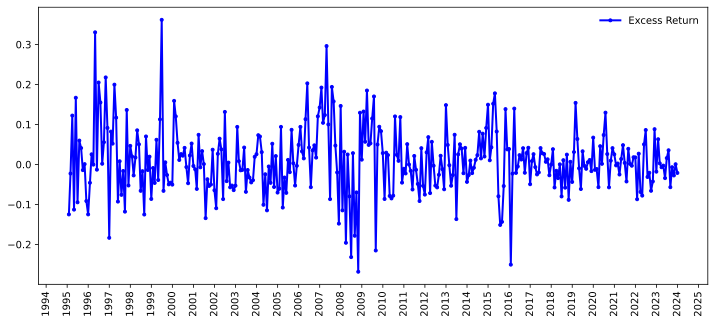

In [53]:
# Plot the Excess Returns

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(
    'ret',  # 要画图的变量名
    '.-b',  # 线的类型
    label = 'Excess Return',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts['1995':'2023'])  # 画图的数据

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)
# 添加图例
plt.legend(loc='upper right', frameon=False, fontsize=10)
plt.show();

## 平稳性检验

In [54]:
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron

# ADF检验
adf_test = adfuller(ts['ret'])
print('ADF检验结果:')
print(f'ADF统计量: {adf_test[0]}')
print(f'p值: {adf_test[1]}')
print(f'滞后阶数: {adf_test[2]}')
print(f'观测值数量: {adf_test[3]}')
print('临界值:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

# Phillips-Perron检验
pp_test = PhillipsPerron(ts['ret'])
print('\nPhillips-Perron检验结果:')
print(pp_test.summary())


ADF检验结果:
ADF统计量: -6.089116499370068
p值: 1.0468386255741855e-07
滞后阶数: 9
观测值数量: 398
临界值:
   1%: -3.4468876315017423
   5%: -2.868829424528516
   10%: -2.570653059771218

Phillips-Perron检验结果:
     Phillips-Perron Test (Z-tau)    
Test Statistic                -18.646
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# 美国股票市场收益率

In [55]:
# import data from Data/F-F_Research_Data_Factors.CSV
ff_data = pd.read_csv('Data/F-F_Research_Data_Factors.csv')
# 重命名列并将数值列除以100
ff_data = ff_data.rename(columns={'Unnamed: 0': 'month'})
# 将月份转换为日期格式并设置为月末
ff_data['month'] = pd.to_datetime(ff_data['month'], format='%Y%m') + MonthEnd(0)
ff_data[['ret_us', 'smb', 'hml', 'rf']] = ff_data[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100
ff_data.set_index('month', inplace=True)
ff_data


,Mkt-RF,SMB,HML,RF,ret_us,smb,hml,rf
month,,,,,,,,
1926-07-31,2.96,-2.56,-2.43,0.22,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,2.64,-1.17,3.82,0.25,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.36,-1.40,0.13,0.23,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-3.24,-0.09,0.70,0.32,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,2.53,-0.10,-0.51,0.31,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...,...,...,...,...
2024-08-31,1.61,-3.55,-1.13,0.48,0.0161,-0.0355,-0.0113,0.0048
2024-09-30,1.74,-0.17,-2.59,0.40,0.0174,-0.0017,-0.0259,0.0040
2024-10-31,-0.97,-1.01,0.89,0.39,-0.0097,-0.0101,0.0089,0.0039


In [56]:
ts = ts.merge(ff_data[['ret_us']], on='month', how='left')
ts

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us
month,,,,,,,
1991-01-31,0.029998,0.036554,1.931395e+06,0.006930,0.023068,0.029624,0.0469
1991-02-28,0.010203,0.021860,1.819734e+06,0.006930,0.003273,0.014930,0.0719
1991-03-31,-0.099663,-0.060425,1.468212e+06,0.006930,-0.106593,-0.067355,0.0265
1991-04-30,-0.079652,-0.031449,2.508786e+06,0.006651,-0.086303,-0.038100,-0.0028
1991-05-31,-0.074521,0.005375,2.321827e+06,0.006092,-0.080613,-0.000717,0.0365
...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,6.000512e+10,0.001118,-0.032586,-0.034803,0.0161
2024-09-30,0.195992,0.227078,7.182264e+10,0.001118,0.194874,0.225960,0.0174
2024-10-31,-0.003409,0.070220,7.162078e+10,0.001118,-0.004527,0.069102,-0.0097


## 中美两国股票市场收益率：图

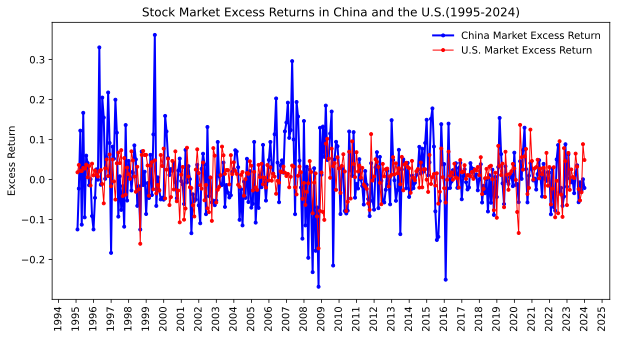

In [57]:
# 创建一个新的图形
fig, ax = plt.subplots(figsize=(10, 5))

# 绘制中国市场超额收益率
ax.plot(
    'ret',  # 要画图的变量名
    '.-b',  # 线的类型
    label = 'China Market Excess Return',  # 这个是线的类别
    linewidth = 2,  # 线的粗细
    data = ts['1995':'2023'])  # 画图的数据

# 绘制美国市场超额收益率
ax.plot(
    'ret_us',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'U.S. Market Excess Return',  # 这个是线的类别
    linewidth = 1,  # 线的粗细
    data = ts['1995':'2023'])  # 画图的数据

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)
# 添加图例
plt.legend(loc='upper right', frameon=False, fontsize=10)
# 添加标题
plt.title('Stock Market Excess Returns in China and the U.S.(1995-2024)')
# 添加y轴标签
plt.ylabel('Excess Return')
plt.show();


# 中美股票市场收益率的关系和预测情况

## 滚动相关系数

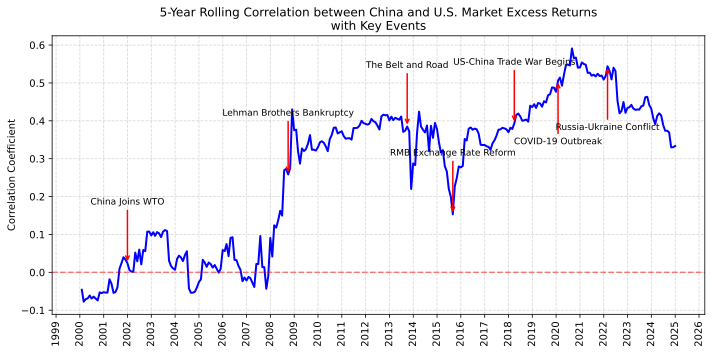

In [58]:
# 计算滚动相关系数
# 从2000年开始，使用前5年的历史数据滚动计算ret和ret_us的相关系数

# 创建一个空的DataFrame来存储滚动相关系数
rolling_corr = pd.DataFrame(index=ts.index, columns=['correlation'])

# 设置窗口大小为5年（60个月）
window_size = 60

# 从2000年开始计算滚动相关系数
for i in range(window_size, len(ts)):
    # 确保当前时间点大于等于2000年
    if ts.index[i].year >= 2000:
        # 获取当前窗口的数据
        window_data = ts.iloc[i-window_size:i]
        # 计算相关系数
        corr = window_data['ret'].corr(window_data['ret_us'])
        # 存储相关系数
        rolling_corr.loc[ts.index[i], 'correlation'] = corr

# 去除NaN值
rolling_corr = rolling_corr.dropna()

# 绘制滚动相关系数的时序图
plt.figure(figsize=(10, 5))
plt.plot(rolling_corr.index, rolling_corr['correlation'], 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# 定义重要事件
events = {
    '2001-12-31': 'China Joins WTO',
    '2008-09-30': 'Lehman Brothers Bankruptcy',
    '2013-09-30': 'The Belt and Road',
    '2015-08-31': 'RMB Exchange Rate Reform',
    '2018-03-31': 'US-China Trade War Begins',
    '2020-01-31': 'COVID-19 Outbreak',
    '2022-02-28': 'Russia-Ukraine Conflict'
}

for date, event in events.items():
    date = pd.to_datetime(date)
    if date not in rolling_corr.index:
        date = rolling_corr.index[rolling_corr.index.get_loc(date, method='nearest')]
    y = rolling_corr.loc[date, 'correlation']

    # 判断事件年份，2020年及以后用向上箭头，文字在下方
    if date.year >= 2020:
        y_text = y - 0.15  # 文字在下方
        va = 'top'
        arrow_style = '->'
        arrowprops = dict(arrowstyle=arrow_style, color='red', lw=1.5)
        plt.annotate(
            event,
            xy=(date, y),
            xytext=(date, y_text),
            textcoords='data',
            arrowprops=arrowprops,
            fontsize=9,
            horizontalalignment='center',
            verticalalignment=va,
            rotation=0
        )
    else:
        y_text = y + 0.15  # 文字在上方
        va = 'bottom'
        arrow_style = '->'
        arrowprops = dict(arrowstyle=arrow_style, color='red', lw=1.5)
        plt.annotate(
            event,
            xy=(date, y),
            xytext=(date, y_text),
            textcoords='data',
            arrowprops=arrowprops,
            fontsize=9,
            horizontalalignment='center',
            verticalalignment=va,
            rotation=0
        )

plt.title('5-Year Rolling Correlation between China and U.S. Market Excess Returns\nwith Key Events')
plt.ylabel('Correlation Coefficient')
plt.grid(True, linestyle='--', alpha=0.5)

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();


## 中美收益率的预测回归

### 美国预测中国股票市场

In [59]:
# 构造滞后一期的ret_us
ts['ret_us_lag1'] = ts['ret_us'].shift(1)
ts['ret_lag1'] = ts['ret'].shift(1)

model = smf.ols('ret ~ ret_us_lag1', data=ts['2010':'2024'])
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(nw_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                     1.104
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.295
Time:                        10:52:13   Log-Likelihood:                 247.82
No. Observations:                 180   AIC:                            -491.6
Df Residuals:                     178   BIC:                            -485.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0023      0.004      0.537      

In [60]:
model = smf.ols('ret ~ ret_us_lag1 + ret_lag1', data=ts['1995':'2024'])
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(nw_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.566
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.210
Time:                        10:52:13   Log-Likelihood:                 392.67
No. Observations:                 360   AIC:                            -779.3
Df Residuals:                     357   BIC:                            -767.7
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0083      0.005      1.734      

### 中国预测美国市场

In [61]:
model = smf.ols('ret_us ~ ret_lag1', data=ts['2010':'2024'])
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(nw_results.summary())
model = smf.ols('ret_us ~ ret_lag1 + ret_us_lag1', data=ts['1995':'2024'])
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(nw_results.summary())


                            OLS Regression Results                            
Dep. Variable:                 ret_us   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1167
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.733
Time:                        10:52:13   Log-Likelihood:                 308.56
No. Observations:                 180   AIC:                            -613.1
Df Residuals:                     178   BIC:                            -606.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0109      0.003      4.147      0.0

# Predictors - 股息率 Price-Dividend Ratio

- Stkcd [证券代码] - 上海A股以上交所公布的证券代码为准，深圳A股以深交所公布的证券代码前加上00
- Disttyp [分配类型] - CA=现金红利，SD=送红股，RO=配股，DS=拆细，GQ=股权分置
- Exdistdt [除权(息)日期] - 以YYYY-MM-DD表示
- Annodt [公告日期] - 以YYYY-MM-DD表示。
- Paydt [支付日期] - 如果分配类型是CA，指现金红利实际到帐日期。如果分配类型是SD、RO、DS、GQ指增加的股票实际上市流通日
- Amount [分配比率] - 以每股作为分配基准单位， 如果分配类型是CA，计量货币为人民币元，计量单位为元，如果分配类型是SD,RO或DS,计量单位为股
- Roprc [配股价格] - 除RO外其他分配类型为0，计量货币为人民币元, 计量单位为元

In [62]:
# Predictors - Price-Dividend Ratio
dividends = pd.read_csv('Data/DPR_Acptl202412.csv')
dividends = dividends[dividends['Disttyp'] == 'CA'] # keep only cash dividends
dividends['month'] = pd.to_datetime(dividends['Exdistdt'],format='%Y-%m-%d') # convert to datetime
dividends['Stkcd'] = dividends['Stkcd'].astype(str).str.zfill(6) # 转换为字符串并补齐6位
dividends

,Stkcd,Disttyp,Exdistdt,Annodt,Paydt,Amount,Roprc,month
1,000001,CA,1991-05-02,NaN,NaN,0.300000,0.0,1991-05-02
4,000001,CA,1992-03-23,1992-03-14,1992-03-23,0.200000,0.0,1992-03-23
6,000001,CA,1993-05-24,1993-05-09,1993-05-24,0.300000,0.0,1993-05-24
9,000001,CA,1994-07-11,1994-07-02,1994-07-14,0.500000,0.0,1994-07-11
12,000001,CA,1995-09-25,1995-09-15,1995-09-27,0.300000,0.0,1995-09-25
...,...,...,...,...,...,...,...,...
62049,900957,CA,2001-05-18,2001-05-12,2001-05-23,0.019947,0.0,2001-05-18
62050,900957,CA,2002-06-12,2002-06-08,2002-06-26,0.019997,0.0,2002-06-12
62051,900957,CA,2003-07-29,2003-07-23,2003-08-13,0.010000,0.0,2003-07-29
62052,920016,CA,2024-11-27,2024-11-19,2024-11-27,0.130000,0.0,2024-11-27


In [63]:
# Perform data cleaning and filtering
dividends = dividends[['Stkcd', 'Disttyp', 'month', 'Amount']].dropna()
dividends = dividends[(dividends['Stkcd'].str.startswith(('0', '3', '6'))) & (~dividends['Stkcd'].str.startswith('688')) & (dividends['Disttyp'] == 'CA')]

# month 列改成月末
dividends['month'] = dividends['month'] + MonthEnd(0)

# Filter rows where 'month' is less than or equal to December 2024
dividends = dividends[dividends['month'] <= '2024-12-31']

dividends

,Stkcd,Disttyp,month,Amount
1,000001,CA,1991-05-31,0.3000
4,000001,CA,1992-03-31,0.2000
6,000001,CA,1993-05-31,0.3000
9,000001,CA,1994-07-31,0.5000
12,000001,CA,1995-09-30,0.3000
...,...,...,...,...
58553,605598,CA,2024-06-30,0.2130
58554,605599,CA,2022-06-30,0.3600
58555,605599,CA,2023-06-30,0.4600
58556,605599,CA,2024-06-30,0.7000


你可以在网盘里下载下面的日度数据：
https://share.weiyun.com/6ZJvOFNb

In [64]:
import pyreadr

# Read the RDS file
ret_day_ST = pyreadr.read_r('Data/ret_day_ST2024.RDS')

# The result is a dictionary where keys are the names of objects in the RDS file.
# Usually, an RDS file contains one object, and you can access it with result[None].
ret_day_ST = ret_day_ST[None]

# Check the DataFrame
ret_day_ST

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,TradingVolume,TradingMoney,CirculationValue,TotalValue,Return_1,Return_2,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,All_shares,A_float_shares,H_float_shares,Pre_shares,ratio
0,000001,1991-04-03,49.00,49.00,49.00,49.00,100.0,5000.0,1.298500e+09,2.376508e+09,0.225000,0.225000,49.000000,49.000000,4.0,1991-04-03,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48500171.0,26500000.0,0.0,0.0,0.54639
1,000001,1991-04-04,48.76,48.76,48.76,48.76,300.0,15000.0,1.292140e+09,2.364868e+09,-0.004898,-0.004898,48.760000,48.760000,4.0,1991-04-03,1.0,NaN,NaN,49.00,-0.004898,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639
2,000001,1991-04-05,48.52,48.52,48.52,48.52,200.0,10000.0,1.285780e+09,2.353228e+09,-0.004922,-0.004922,48.520000,48.520000,4.0,1991-04-03,1.0,NaN,NaN,48.76,-0.004922,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639
3,000001,1991-04-06,48.28,48.28,48.28,48.28,700.0,34000.0,1.279420e+09,2.341588e+09,-0.004946,-0.004946,48.280000,48.280000,4.0,1991-04-03,1.0,NaN,NaN,48.52,-0.004946,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639
4,000001,1991-04-08,48.04,48.04,48.04,48.04,200.0,10000.0,1.273060e+09,2.329948e+09,-0.004971,-0.004971,48.040000,48.040000,4.0,1991-04-03,1.0,NaN,NaN,48.28,-0.004971,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15257495,605599,2024-12-25,11.32,11.42,11.12,11.38,3357400.0,37892070.0,8.851111e+09,8.851111e+09,0.006189,0.006189,12.837053,11.379976,1.0,2024-09-09,1.0,0,0.0,11.31,0.006189,10.18,12.44,0,777777800.0,777777800.0,0.0,0.0,1.00000
15257496,605599,2024-12-26,11.38,11.57,11.27,11.35,3268799.0,37208491.0,8.827778e+09,8.827778e+09,-0.002636,-0.002636,12.803212,11.349976,1.0,2024-09-09,1.0,0,0.0,11.38,-0.002636,10.24,12.52,0,777777800.0,777777800.0,0.0,0.0,1.00000
15257497,605599,2024-12-27,11.34,11.56,11.24,11.50,3191851.0,36510958.0,8.944445e+09,8.944445e+09,0.013216,0.013216,12.972417,11.499976,1.0,2024-09-09,1.0,0,0.0,11.35,0.013216,10.22,12.49,0,777777800.0,777777800.0,0.0,0.0,1.00000
15257498,605599,2024-12-30,11.50,11.54,11.26,11.31,3091180.0,35133841.0,8.796667e+09,8.796667e+09,-0.016522,-0.016522,12.758090,11.309976,1.0,2024-09-09,1.0,0,0.0,11.50,-0.016522,10.35,12.65,0,777777800.0,777777800.0,0.0,0.0,1.00000


In [65]:
# 取每个股票每个月最后一个交易日的数据
ret_day_ST['month'] = pd.to_datetime(ret_day_ST['Day'],format='%Y-%m-%d') + MonthEnd(0)
ret_day_ST = ret_day_ST.groupby(['Stkcd', 'month']).tail(1)
ret_day_ST

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,TradingVolume,TradingMoney,CirculationValue,TotalValue,Return_1,Return_2,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,All_shares,A_float_shares,H_float_shares,Pre_shares,ratio,month
19,000001,1991-04-30,43.68,43.68,43.68,43.68,200.0,9000.0,1.157520e+09,2.118487e+09,-0.005011,-0.005011,43.680000,43.680000,4.0,1991-04-03,1.0,NaN,NaN,43.90,-0.005011,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639,1991-04-30
43,000001,1991-05-31,38.34,38.34,38.34,38.34,100.0,4000.0,1.016010e+09,1.859497e+09,-0.004931,-0.004931,38.340000,38.340000,4.0,1991-04-03,1.0,NaN,NaN,38.53,-0.004931,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639,1991-05-31
66,000001,1991-06-28,33.99,33.99,33.99,33.99,200.0,7000.0,9.007350e+08,1.648521e+09,-0.004977,-0.004977,33.990000,33.990000,4.0,1991-04-03,1.0,NaN,NaN,34.16,-0.004977,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639,1991-06-30
82,000001,1991-07-31,29.54,29.54,29.54,29.54,100.0,2954.0,7.828100e+08,1.432695e+09,-0.005052,-0.005052,29.540000,29.540000,4.0,1991-04-03,1.0,NaN,NaN,29.69,-0.005052,NaN,NaN,0,48500171.0,26500000.0,0.0,0.0,0.54639,1991-07-31
97,000001,1991-08-31,15.05,15.05,14.85,15.00,120000.0,1798460.0,6.748338e+08,1.346275e+09,-0.003322,-0.003322,17.381702,17.381702,4.0,1991-08-01,1.0,NaN,NaN,15.05,-0.003322,NaN,NaN,0,89751643.0,44988921.0,0.0,0.0,0.50126,1991-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15257419,605599,2024-08-30,11.09,11.09,10.31,10.74,10687601.0,112719683.0,6.300920e+09,8.353334e+09,-0.038496,-0.038496,12.115111,10.739978,1.0,2022-09-09,1.0,0,0.0,11.17,-0.038496,10.05,12.29,0,777777800.0,586677800.0,0.0,0.0,0.75430,2024-08-31
15257438,605599,2024-09-30,11.40,11.98,11.08,11.89,10909705.0,126054678.0,9.247778e+09,9.247778e+09,0.084854,0.084854,13.412353,11.889974,1.0,2024-09-09,1.0,0,0.0,10.96,0.084854,9.86,12.06,0,777777800.0,777777800.0,0.0,0.0,1.00000,2024-09-30
15257456,605599,2024-10-31,10.65,10.69,10.52,10.65,4357224.0,46206639.0,8.283334e+09,8.283334e+09,-0.002809,-0.002809,12.013586,10.649978,1.0,2024-09-09,1.0,0,0.0,10.68,-0.002809,9.61,11.75,0,777777800.0,777777800.0,0.0,0.0,1.00000,2024-10-31
15257477,605599,2024-11-29,11.21,11.57,11.19,11.50,9008193.0,103068672.0,8.944445e+09,8.944445e+09,0.023132,0.023132,12.972415,11.499975,1.0,2024-09-09,1.0,0,0.0,11.24,0.023132,10.12,12.36,0,777777800.0,777777800.0,0.0,0.0,1.00000,2024-11-30


In [66]:
# Merge 'Dividend' with filtered 'ret_day_ST' 
merge_condition = ret_day_ST[['Stkcd', 'month', 'CirculationValue', 'A_float_shares', 'Clsprc']]
Dividend = pd.merge(dividends, merge_condition, on=['Stkcd', 'month'], how='right')
Dividend.sort_values(by=['Stkcd', 'month'], inplace=True)
Dividend

,Stkcd,Disttyp,month,Amount,CirculationValue,A_float_shares,Clsprc
0,000001,NaN,1991-04-30,NaN,1.157520e+09,26500000.0,43.68
1,000001,CA,1991-05-31,0.3,1.016010e+09,26500000.0,38.34
2,000001,NaN,1991-06-30,NaN,9.007350e+08,26500000.0,33.99
3,000001,NaN,1991-07-31,NaN,7.828100e+08,26500000.0,29.54
4,000001,NaN,1991-08-31,NaN,6.748338e+08,44988921.0,15.00
...,...,...,...,...,...,...,...
769037,605599,NaN,2024-08-31,NaN,6.300920e+09,586677800.0,10.74
769038,605599,NaN,2024-09-30,NaN,9.247778e+09,777777800.0,11.89
769039,605599,NaN,2024-10-31,NaN,8.283334e+09,777777800.0,10.65
769040,605599,NaN,2024-11-30,NaN,8.944445e+09,777777800.0,11.50


In [67]:
# Compute market values and dividends
Dividend['d'] = Dividend['Amount'].astype(float) * Dividend['A_float_shares'].astype(float)

# Calculate the sum of dividends for each month 不考虑缺失值
# 去掉Amount列中的缺失值 
Dividend_market = Dividend.dropna(subset=['Amount']).groupby('month').agg({'d':'sum'}).reset_index()
Value_market = Dividend.dropna(subset=['CirculationValue']).groupby('month').agg({'CirculationValue':'sum'}).reset_index()

# Merge the two DataFrames
Dividend_market = pd.merge(Dividend_market, Value_market, on='month', how='right')
Dividend_market


,month,d,CirculationValue
0,1990-12-31,NaN,6.241660e+08
1,1991-01-31,NaN,1.931395e+09
2,1991-02-28,NaN,1.830458e+09
3,1991-03-31,NaN,1.468212e+09
4,1991-04-30,NaN,2.508786e+09
...,...,...,...
404,2024-08-31,1.037124e+11,6.000537e+13
405,2024-09-30,9.155628e+10,7.182304e+13
406,2024-10-31,6.644569e+10,7.162070e+13
407,2024-11-30,4.675402e+10,7.240856e+13


In [68]:
# Calculate lags of dividends for 11 months
for i in range(1, 12):
    Dividend_market[f'd{i}'] = Dividend_market['d'].shift(i)

# Calculate the sum of dividends including the current and previous 11 months
Dividend_market['sum_d'] = Dividend_market[['d'] + [f'd{i}' for i in range(1, 12)]].sum(axis=1)
Dividend_market

,month,d,CirculationValue,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,sum_d
0,1990-12-31,NaN,6.241660e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
1,1991-01-31,NaN,1.931395e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
2,1991-02-28,NaN,1.830458e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
3,1991-03-31,NaN,1.468212e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
4,1991-04-30,NaN,2.508786e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,2024-08-31,1.037124e+11,6.000537e+13,6.346337e+11,5.359413e+11,1.943693e+11,4.765301e+10,1.049909e+09,1.800660e+09,1.577511e+09,3.470961e+10,1.138245e+10,2.278053e+10,6.013142e+10,1.649742e+12
405,2024-09-30,9.155628e+10,7.182304e+13,1.037124e+11,6.346337e+11,5.359413e+11,1.943693e+11,4.765301e+10,1.049909e+09,1.800660e+09,1.577511e+09,3.470961e+10,1.138245e+10,2.278053e+10,1.681167e+12
406,2024-10-31,6.644569e+10,7.162070e+13,9.155628e+10,1.037124e+11,6.346337e+11,5.359413e+11,1.943693e+11,4.765301e+10,1.049909e+09,1.800660e+09,1.577511e+09,3.470961e+10,1.138245e+10,1.724832e+12
407,2024-11-30,4.675402e+10,7.240856e+13,6.644569e+10,9.155628e+10,1.037124e+11,6.346337e+11,5.359413e+11,1.943693e+11,4.765301e+10,1.049909e+09,1.800660e+09,1.577511e+09,3.470961e+10,1.760203e+12


In [69]:
# Calculate the Price-Dividend ratio
Dividend_market['pd'] = np.log(Dividend_market['CirculationValue'] / Dividend_market['sum_d'])

# Prepare the final output as needed
Price_dividend_mon = Dividend_market[['month', 'pd']]

Price_dividend_mon.set_index('month', inplace=True)
Price_dividend_mon = Price_dividend_mon['1995-01-01':'2024-12-31']
Price_dividend_mon

,pd
month,
1995-01-31,4.084782
1995-02-28,4.081370
1995-03-31,4.238190
1995-04-30,4.117053
1995-05-31,4.185583
...,...
2024-08-31,3.593815
2024-09-30,3.754717
2024-10-31,3.726254


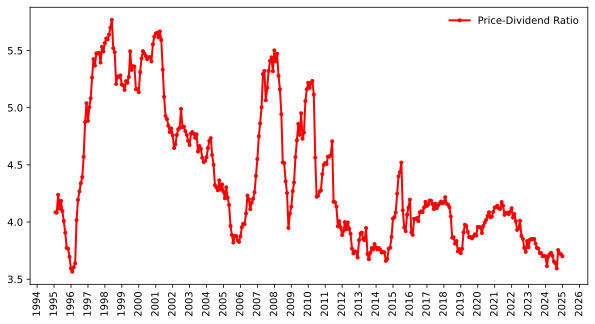

In [70]:
# Plot the Price-Dividend Ratio
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'pd',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'Price-Dividend Ratio',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = Price_dividend_mon)  # 画图的数据

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)
# 添加图例
plt.legend(loc='upper right', frameon=False, fontsize=10)
plt.show();

## 股息率和收益率：图

In [71]:
ts_pd = ts.merge(Price_dividend_mon, on='month', how='left')
ts_pd = ts_pd['1995-01-01':'2024-12-31']
ts_pd

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us,ret_us_lag1,ret_lag1,pd
month,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,7.195238e+07,0.008719,-0.125017,-0.134556,0.0180,0.0086,-0.063907,4.084782
1995-02-28,-0.014059,-0.013693,7.170322e+07,0.008719,-0.022778,-0.022412,0.0363,0.0180,-0.125017,4.081370
1995-03-31,0.130882,0.146959,8.217532e+07,0.008719,0.122163,0.138240,0.0219,0.0363,-0.022778,4.238190
1995-04-30,-0.104304,-0.101424,7.431161e+07,0.008719,-0.113023,-0.110143,0.0211,0.0219,0.122163,4.117053
1995-05-31,0.175455,0.199416,8.732088e+07,0.008719,0.166736,0.190697,0.0290,0.0211,-0.113023,4.185583
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,6.000512e+10,0.001118,-0.032586,-0.034803,0.0161,0.0124,-0.000624,3.593815
2024-09-30,0.195992,0.227078,7.182264e+10,0.001118,0.194874,0.225960,0.0174,0.0161,-0.032586,3.754717
2024-10-31,-0.003409,0.070220,7.162078e+10,0.001118,-0.004527,0.069102,-0.0097,0.0174,0.194874,3.726254


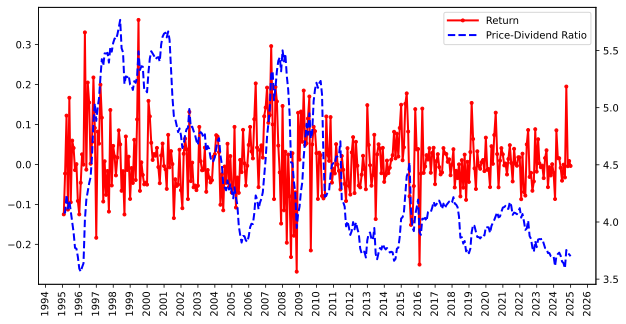

In [72]:
# plot ret pd
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'ret',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'Return',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_pd)  # 画图的数据
# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(
    'pd',  # 要画图的变量名
    '--b',  # 线的类型
    label = 'Price-Dividend Ratio',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_pd)  # 画图的数据


# 添加图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=True, fontsize=10, handlelength=3)
plt.show();


## 预测回归

In [73]:
ts_pd['pd_lag1'] = ts_pd['pd'].shift(1)
ts_pd

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us,ret_us_lag1,ret_lag1,pd,pd_lag1
month,,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,7.195238e+07,0.008719,-0.125017,-0.134556,0.0180,0.0086,-0.063907,4.084782,NaN
1995-02-28,-0.014059,-0.013693,7.170322e+07,0.008719,-0.022778,-0.022412,0.0363,0.0180,-0.125017,4.081370,4.084782
1995-03-31,0.130882,0.146959,8.217532e+07,0.008719,0.122163,0.138240,0.0219,0.0363,-0.022778,4.238190,4.081370
1995-04-30,-0.104304,-0.101424,7.431161e+07,0.008719,-0.113023,-0.110143,0.0211,0.0219,0.122163,4.117053,4.238190
1995-05-31,0.175455,0.199416,8.732088e+07,0.008719,0.166736,0.190697,0.0290,0.0211,-0.113023,4.185583,4.117053
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,6.000512e+10,0.001118,-0.032586,-0.034803,0.0161,0.0124,-0.000624,3.593815,3.640346
2024-09-30,0.195992,0.227078,7.182264e+10,0.001118,0.194874,0.225960,0.0174,0.0161,-0.032586,3.754717,3.593815
2024-10-31,-0.003409,0.070220,7.162078e+10,0.001118,-0.004527,0.069102,-0.0097,0.0174,0.194874,3.726254,3.754717


In [74]:
model = smf.ols('ret ~ pd_lag1', data=ts_pd['2000-01-01':'2024-12-31'])
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(nw_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4710
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.493
Time:                        10:52:51   Log-Likelihood:                 349.26
No. Observations:                 300   AIC:                            -694.5
Df Residuals:                     298   BIC:                            -687.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0377      0.042      0.889      0.3

## 长期预测 Long Horizon Forecast

In [75]:
# 计算不同时间跨度的累计收益率
# k代表未来几个月的时间跨度
for k in [1, 3, 6, 12, 24, 36, 48, 60]:
    # 计算未来k个月的累计收益率
    ts_pd[f'ret_{k}m'] = ts_pd['ret'].rolling(window=k).sum().shift(-k)
    
    # 由于是预测未来k个月的收益率，最后k个月的数据无法计算完整，因此会被设置为NaN
    ts_pd.loc[ts_pd.index[-k:], f'ret_{k}m'] = np.nan

# 显示结果
print("不同时间跨度的累计收益率：")
print(ts_pd[[f'ret_{k}m' for k in [1, 3, 6, 12, 24, 36, 48, 60]]].tail(10))


不同时间跨度的累计收益率：
              ret_1m    ret_3m    ret_6m  ret_12m  ret_24m  ret_36m  ret_48m  \
month                                                                          
2024-03-31  0.015524 -0.033746  0.127918      NaN      NaN      NaN      NaN   
2024-04-30 -0.008571 -0.049894  0.107867      NaN      NaN      NaN      NaN   
2024-05-31 -0.040699 -0.073909  0.125044      NaN      NaN      NaN      NaN   
2024-06-30 -0.000624  0.161664  0.161946      NaN      NaN      NaN      NaN   
2024-07-31 -0.032586  0.157761       NaN      NaN      NaN      NaN      NaN   
2024-08-31  0.194874  0.198953       NaN      NaN      NaN      NaN      NaN   
2024-09-30 -0.004527  0.000282       NaN      NaN      NaN      NaN      NaN   
2024-10-31  0.008606       NaN       NaN      NaN      NaN      NaN      NaN   
2024-11-30 -0.003797       NaN       NaN      NaN      NaN      NaN      NaN   
2024-12-31       NaN       NaN       NaN      NaN      NaN      NaN      NaN   

            ret_60m  
mon

In [76]:
from statsmodels.iolib.summary2 import summary_col

# pd预测未来长期收益率
model_3 = smf.ols('ret_3m ~ pd', data=ts_pd['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_6 = smf.ols('ret_6m ~ pd', data=ts_pd['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_12 = smf.ols('ret_12m ~ pd', data=ts_pd['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_24 = smf.ols('ret_24m ~ pd', data=ts_pd['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_36 = smf.ols('ret_36m ~ pd', data=ts_pd['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_48 = smf.ols('ret_48m ~ pd', data=ts_pd['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_60 = smf.ols('ret_60m ~ pd', data=ts_pd['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})

info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}",
             'R-squared': lambda x: f"{x.rsquared:.3f}",
             'Adj. R-squared': lambda x: f"{x.rsquared_adj:.3f}"}

results_table = summary_col(
    results=[model_3, model_6, model_12, model_24, model_36, model_48, model_60],
    float_format='%0.3f',  # 数据显示格式，3位小数
    stars=True,  # 显示显著性星号
    model_names=['3 months', '6 months', '12 months', '24 months', '36 months', '48 months', '60 months'],
    info_dict=info_dict,
    regressor_order=['Intercept', 'pd']  # 回归系数展示顺序
)

results_table.add_title('Table - OLS Regressions: 价格股息比预测未来长期市场收益')

print(results_table)

                      Table - OLS Regressions: 价格股息比预测未来长期市场收益
                 3 months 6 months 12 months 24 months 36 months 48 months 60 months
------------------------------------------------------------------------------------
Intercept        0.197*   0.518**  1.226***  2.134***  2.458***  2.700***  2.733*** 
                 (0.118)  (0.222)  (0.325)   (0.441)   (0.357)   (0.504)   (0.635)  
pd               -0.042   -0.113** -0.269*** -0.460*** -0.512*** -0.541*** -0.521***
                 (0.029)  (0.053)  (0.074)   (0.091)   (0.075)   (0.112)   (0.144)  
R-squared        0.023    0.065    0.150     0.249     0.245     0.238     0.215    
R-squared Adj.   0.019    0.061    0.147     0.246     0.242     0.235     0.212    
Adj. R-squared   0.019    0.061    0.147     0.246     0.242     0.235     0.212    
No. observations 297      294      288       276       264       252       240      
R-squared        0.023    0.065    0.150     0.249     0.245     0.238     0.215    
St

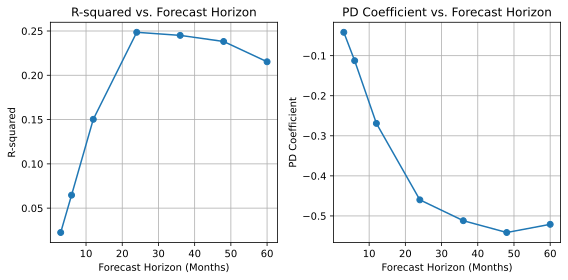

In [77]:
# 可视化R方和系数随预测期限的变化 (英文版)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
horizons = [3, 6, 12, 24, 36, 48, 60]

# R方变化图
ax[0].plot(horizons, [model_3.rsquared, model_6.rsquared, model_12.rsquared, 
                     model_24.rsquared, model_36.rsquared, model_48.rsquared, model_60.rsquared], 
         marker='o', linestyle='-')
ax[0].set_xlabel('Forecast Horizon (Months)')
ax[0].set_ylabel('R-squared')
ax[0].set_title('R-squared vs. Forecast Horizon')
ax[0].grid(True)

# 系数变化图
ax[1].plot(horizons, [model_3.params['pd'], model_6.params['pd'], model_12.params['pd'], 
                     model_24.params['pd'], model_36.params['pd'], model_48.params['pd'], model_60.params['pd']], 
         marker='o', linestyle='-')
ax[1].set_xlabel('Forecast Horizon (Months)')
ax[1].set_ylabel('PD Coefficient')
ax[1].set_title('PD Coefficient vs. Forecast Horizon')
ax[1].grid(True)

plt.tight_layout()
plt.show();

## pd和未来24个月累计收益率图

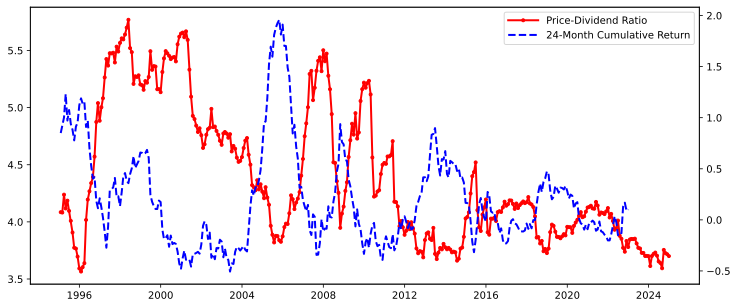

In [78]:
# plot pd and ret_24m
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    'pd',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'Price-Dividend Ratio',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_pd)  # 画图的数据

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)

ax2 = ax.twinx()
ax2.plot(
    'ret_24m',  # 要画图的变量名
    '--b',  # 线的类型
    label = '24-Month Cumulative Return',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_pd)  # 画图的数据

# 添加图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=True, fontsize=10, handlelength=3)
plt.show();



# 收益与风险的关系 Risk-Return Trade Off

- French, Kenneth R., G. William Schwert, and Robert F. Stambaugh, 1987, Expected stock returns and volatility, Journal of Financial Economics 19, 3–29.
- Guo, Hui, and Robert F. Whitelaw, 2006, Uncovering the risk-return relation in the stock market, The Journal of Finance 61, 1433–1463.
- Guo, Hui, and Yu-Jou Pai, 2021, The risk-return relation puzzle, Pacific-Basin Finance Journal 69, 101652.
- Cheng, Hang, Hui Guo, and Yongdong Shi, 2024, Multifactor conditional equity premium model: Evidence from China’s stock market, Journal of Banking & Finance 161, 107117.

$$
E_{t} (R_{t+1}) = \gamma * E_t (\sigma_{t+1} ^2)
$$

$$
R _{t+1} = a + b * Var_{t}
$$

- 通常我们在月度数据中使用日收益率的平方和度量Var

- 无风险利率

In [79]:
riskfree = pd.read_csv('Data/TRD_Nrrate2024.csv')
riskfree = riskfree[2:]  # 删除前两行
riskfree_day = riskfree[['Clsdt', 'Nrrdaydt']].rename(columns={'Clsdt': 'Day', 'Nrrdaydt': 'rfday'})
riskfree_day['rfday'] = riskfree_day['rfday'].astype(float) / 100
riskfree_day['Day'] = pd.to_datetime(riskfree_day['Day'])
riskfree_day

,Day,rfday
2,1990-12-19,0.000227
3,1990-12-20,0.000227
4,1990-12-21,0.000227
5,1990-12-22,0.000227
6,1990-12-23,0.000227
...,...,...
12429,2024-12-27,0.000037
12430,2024-12-28,0.000037
12431,2024-12-29,0.000037
12432,2024-12-30,0.000037


- 日度市场收益率数据

In [80]:
Marketret_day_stock = pd.read_csv('Data/TRD_Cndalym2024.csv')
Marketret_day_stock 

,Markettype,Trddt,Cnshrtrdtl,Cnvaltrdtl,Cdretwdeq,Cdretmdeq,Cdretwdos,Cdretmdos,Cdretwdtl,Cdretmdtl,Cdnstkcal
0,5,1990-12-19,1412,4.943106e+05,2.680429,2.680429,NaN,NaN,NaN,NaN,4
1,15,1990-12-19,1412,4.943106e+05,2.680429,2.680429,NaN,NaN,NaN,NaN,4
2,21,1990-12-19,1412,4.943106e+05,2.680429,2.680429,NaN,NaN,NaN,NaN,4
3,31,1990-12-19,1412,4.943106e+05,2.680429,2.680429,NaN,NaN,NaN,NaN,4
4,37,1990-12-19,1412,4.943106e+05,2.680429,2.680429,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...
158426,63,2024-12-31,114938407066,1.345763e+12,-0.024475,-0.024478,-0.019188,-0.019190,-0.019905,-0.019907,5188
158427,101,2024-12-31,95722523181,1.006431e+12,-0.020067,-0.020070,-0.017328,-0.017330,-0.017676,-0.017678,4005
158428,111,2024-12-31,95777160273,1.006643e+12,-0.019879,-0.019881,-0.017308,-0.017310,-0.017653,-0.017656,4086
158429,117,2024-12-31,115665364529,1.358630e+12,-0.023270,-0.023272,-0.019139,-0.019141,-0.019803,-0.019805,5369


In [81]:
Marketret_day_stock = Marketret_day_stock[Marketret_day_stock['Markettype'] == 21]
Marketret_day_stock = Marketret_day_stock[['Trddt', 'Cdretwdos', 'Cdretwdeq']].dropna()
Marketret_day_stock.columns = ['Day', 'MarketR', 'MarketR_e']
Marketret_day_stock

,Day,MarketR,MarketR_e
19,1990-12-20,0.050067,0.752547
36,1990-12-21,0.039671,67.771445
53,1990-12-24,0.049380,0.049638
70,1990-12-25,0.049938,0.050022
87,1990-12-26,0.050151,0.050151
...,...,...,...
158340,2024-12-25,-0.004361,-0.019226
158359,2024-12-26,0.002969,0.011729
158378,2024-12-27,0.002119,0.008489
158397,2024-12-30,0.000660,-0.008647


In [82]:
Marketret_day_stock['Day'] = pd.to_datetime(Marketret_day_stock['Day'],format='%Y-%m-%d')
Marketret_day_stock['month'] = Marketret_day_stock['Day'] + MonthEnd(0)
Marketret_day_stock = Marketret_day_stock.merge(riskfree_day, on='Day', how='left')
Marketret_day_stock['er'] = Marketret_day_stock['MarketR'].astype(float) - Marketret_day_stock['rfday'].astype(float)
Marketret_day_stock

,Day,MarketR,MarketR_e,month,rfday,er
0,1990-12-20,0.050067,0.752547,1990-12-31,0.000227,0.049840
1,1990-12-21,0.039671,67.771445,1990-12-31,0.000227,0.039444
2,1990-12-24,0.049380,0.049638,1990-12-31,0.000227,0.049153
3,1990-12-25,0.049938,0.050022,1990-12-31,0.000227,0.049711
4,1990-12-26,0.050151,0.050151,1990-12-31,0.000227,0.049924
...,...,...,...,...,...,...
8356,2024-12-25,-0.004361,-0.019226,2024-12-31,0.000037,-0.004398
8357,2024-12-26,0.002969,0.011729,2024-12-31,0.000037,0.002932
8358,2024-12-27,0.002119,0.008489,2024-12-31,0.000037,0.002082
8359,2024-12-30,0.000660,-0.008647,2024-12-31,0.000037,0.000623


## 月度市场波动率

In [83]:
# 计算滞后期收益率 range(1,5)是1,2,3,4
for i in range(1, 5):
    Marketret_day_stock[f'er{i}'] = Marketret_day_stock['er'].shift(i)

# 定义方差计算函数 - 使用向量化操作提高效率
def calc_variance(df):
    """
    计算不同阶数的市场收益率方差
    mv: 简单方差
    mv1-mv4: 含自相关项的调整方差
    """
    er = df['er'].values
    result = {'mv': np.sum(er ** 2)}
    
    # 累积添加自相关项
    cum_sum = er ** 2
    for i in range(1, 5):
        er_i = df[f'er{i}'].values
        # 使用广播操作计算交叉项
        cross_term = 2 * er * er_i
        cum_sum = cum_sum + cross_term
        result[f'mv{i}'] = np.sum(cum_sum)
    
    return result

# 按月分组计算方差
Marketvariance_mon_stock = (Marketret_day_stock
                           .groupby('month', group_keys=False)
                           .apply(calc_variance,include_groups=False)
                           .apply(pd.Series)  # 直接转换为DataFrame
                           .reset_index())

# 设置月份为索引
Marketvariance_mon_stock.set_index('month', inplace=True)

# 处理负方差 - 使用列表循环简化逻辑
variance_cols = ['mv', 'mv1', 'mv2', 'mv3', 'mv4','mv5']
for i in range(1, 5):
    Marketvariance_mon_stock[f'mv{i}'] = np.maximum(
        Marketvariance_mon_stock[f'mv{i}'],
        Marketvariance_mon_stock[variance_cols[i-1]]  # 如果为负则使用前一阶方差
    )

# 显示结果
Marketvariance_mon_stock

,mv,mv1,mv2,mv3,mv4
month,,,,,
1990-12-31,0.011709,NaN,NaN,NaN,NaN
1991-01-31,0.000690,0.001566,0.002593,0.003461,0.005044
1991-02-28,0.000418,0.000707,0.000853,0.000853,0.000853
1991-03-31,0.001229,0.002925,0.004650,0.006369,0.008306
1991-04-30,0.000855,0.001973,0.003364,0.004531,0.005860
...,...,...,...,...,...
2024-08-31,0.000881,0.000881,0.000881,0.000881,0.000881
2024-09-30,0.012481,0.023868,0.034838,0.041347,0.049594
2024-10-31,0.011652,0.011652,0.011652,0.011652,0.011652


## 图

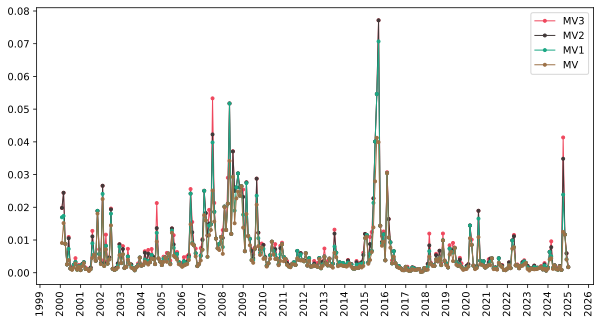

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'mv3',
    '.-', 
    color = '#EF475D',
    label = 'MV3',  
    linewidth = 1,  
    data = Marketvariance_mon_stock['2000':])  

ax.plot(
    'mv2',
    '.-', 
    color = '#403838',
    label = 'MV2',  
    linewidth = 1,  
    data = Marketvariance_mon_stock['2000':])

ax.plot(
    'mv1',
    '.-', 
    color = '#1BA784',
    label = 'MV1',  
    linewidth = 1,  
    data = Marketvariance_mon_stock['2000':])

ax.plot(
    'mv',
    '.-', 
    color = '#9C7147',
    label = 'MV',  
    linewidth = 1,  
    data = Marketvariance_mon_stock['2000':])

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)

# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())

# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)

# 显示图例
plt.legend()

plt.show();

## 回归预测

In [85]:
ts_mv = ts_pd.merge(Marketvariance_mon_stock, on='month', how='left')
ts_mv

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us,ret_us_lag1,ret_lag1,pd,pd_lag1,ret_1m,ret_3m,ret_6m,ret_12m,ret_24m,ret_36m,ret_48m,ret_60m,mv,mv1,mv2,mv3,mv4
month,,,,,,,,,,,,,,,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,7.195238e+07,0.008719,-0.125017,-0.134556,0.0180,0.0086,-0.063907,4.084782,NaN,-0.022778,-0.013638,0.118028,-0.116804,0.849761,1.072520,0.969609,1.346000,0.005917,0.005917,0.009039,0.010699,0.010699
1995-02-28,-0.014059,-0.013693,7.170322e+07,0.008719,-0.022778,-0.022412,0.0363,0.0180,-0.125017,4.081370,4.084782,0.122163,0.175876,0.181846,-0.068728,0.924521,1.067777,0.946063,1.488946,0.018659,0.018659,0.018659,0.018659,0.018659
1995-03-31,0.130882,0.146959,8.217532e+07,0.008719,0.122163,0.138240,0.0219,0.0363,-0.022778,4.238190,4.081370,-0.113023,-0.041028,0.045422,-0.191401,1.001870,0.962820,0.885519,1.420853,0.010824,0.016590,0.016590,0.016590,0.016590
1995-04-30,-0.104304,-0.101424,7.431161e+07,0.008719,-0.113023,-0.110143,0.0211,0.0219,0.122163,4.117053,4.238190,0.166736,0.131666,0.159207,0.251999,1.231923,1.161154,0.959536,1.545034,0.007637,0.009507,0.009507,0.009507,0.011160
1995-05-31,0.175455,0.199416,8.732088e+07,0.008719,0.166736,0.190697,0.0290,0.0211,-0.113023,4.185583,4.117053,-0.094741,0.005970,-0.099054,0.072163,0.972245,1.044637,0.905517,1.404133,0.149315,0.218157,0.228720,0.228720,0.228720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,6.000512e+10,0.001118,-0.032586,-0.034803,0.0161,0.0124,-0.000624,3.593815,3.640346,0.194874,0.198953,NaN,NaN,NaN,NaN,NaN,NaN,0.000881,0.000881,0.000881,0.000881,0.000881
2024-09-30,0.195992,0.227078,7.182264e+10,0.001118,0.194874,0.225960,0.0174,0.0161,-0.032586,3.754717,3.593815,-0.004527,0.000282,NaN,NaN,NaN,NaN,NaN,NaN,0.012481,0.023868,0.034838,0.041347,0.049594
2024-10-31,-0.003409,0.070220,7.162078e+10,0.001118,-0.004527,0.069102,-0.0097,0.0174,0.194874,3.726254,3.754717,0.008606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011652,0.011652,0.011652,0.011652,0.011652


In [86]:
from statsmodels.iolib.summary2 import summary_col

# 创建滞后一期的波动率指标
for col in ['mv', 'mv1', 'mv2', 'mv3', 'mv4']:
    ts_mv[f'{col}_lag1'] = ts_mv[col].shift(1)

# 去除缺失值
ts_mv_reg = ts_mv.dropna(subset=['ret', 'mv_lag1', 'mv1_lag1', 'mv2_lag1', 'mv3_lag1', 'mv4_lag1'])

# 使用不同波动率衡量指标进行预测
model_mv = smf.ols('ret ~ mv_lag1', data=ts_mv_reg['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_mv1 = smf.ols('ret ~ mv1_lag1', data=ts_mv_reg['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_mv2 = smf.ols('ret ~ mv2_lag1', data=ts_mv_reg['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_mv3 = smf.ols('ret ~ mv3_lag1', data=ts_mv_reg['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model_mv4 = smf.ols('ret ~ mv4_lag1', data=ts_mv_reg['2000-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})

# 设置结果表的信息
info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}",
             'R-squared': lambda x: f"{x.rsquared:.3f}",
             'Adj. R-squared': lambda x: f"{x.rsquared_adj:.3f}"}

# 创建汇总表
results_table = summary_col(
    results=[model_mv, model_mv1, model_mv2, model_mv3, model_mv4],
    float_format='%0.3f',  # 数据显示格式，3位小数
    stars=True,  # 显示显著性星号
    model_names=['MV', 'MV1', 'MV2', 'MV3', 'MV4'],
    info_dict=info_dict,
    regressor_order=['Intercept', 'mv_lag1', 'mv1_lag1', 'mv2_lag1', 'mv3_lag1', 'mv4_lag1']
)

results_table.add_title('Table - OLS Regressions: Market Volatility Predicting Future Returns')

print(results_table)

Table - OLS Regressions: Market Volatility Predicting Future Returns
                    MV     MV1     MV2     MV3     MV4  
--------------------------------------------------------
Intercept        0.009   0.009   0.008   0.007   0.006  
                 (0.006) (0.006) (0.006) (0.006) (0.006)
mv_lag1          -0.488                                 
                 (1.152)                                
mv1_lag1                 -0.433                         
                         (0.903)                        
mv2_lag1                         -0.165                 
                                 (0.893)                
mv3_lag1                                 0.001          
                                         (0.886)        
mv4_lag1                                         0.133  
                                                 (0.770)
R-squared        0.002   0.002   0.000   0.000   0.000  
R-squared Adj.   -0.002  -0.001  -0.003  -0.003  -0.003 
Adj. R-squared   -0

In [87]:
# mv3 lag 和 pd lag 一起回归
model_mv3_pd = smf.ols('ret ~ mv3_lag1 + pd_lag1', data=ts_mv_reg['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})

print(model_mv3_pd.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4471
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.640
Time:                        10:52:52   Log-Likelihood:                 390.75
No. Observations:                 359   AIC:                            -775.5
Df Residuals:                     356   BIC:                            -763.8
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0377      0.030      1.252      0.2

# 换手率 Turnover

- 个股日数据2024：https://share.weiyun.com/MBk9ZhVr

Reference:
- Glosten, Lawrence R., and Paul R. Milgrom, 1985, Bid, ask and transaction prices in a specialist market with heterogeneously informed traders, Journal of Financial Economics 14, 71–100.
    - 信息不对称在短期内可能刺激交易量和价格波动同时增加
- Black, Fischer, 1986, Noise, The Journal of Finance 41, 528–543.
- Kyle, Albert S., 1985, Continuous auctions and insider trading, Econometrica 53, 1315–1335.


In [88]:
# Read the RDS file
ret_day = pyreadr.read_r('Data/ret_day2024.RDS')

# The result is a dictionary where keys are the names of objects in the RDS file.
# Usually, an RDS file contains one object, and you can access it with result[None].
ret_day = ret_day[None]

# Check the DataFrame
ret_day

,Day,Stkcd,y,Q,month,Opnprc,Hiprc,Loprc,Clsprc,TradingVolume,TradingMoney,CirculationValue,TotalValue,Return_1,Return_2,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,All_shares,A_float_shares,H_float_shares,Pre_shares,ratio,Freq,Freq_Q,Freq_y,yuemo,jimo,rfday,r
0,1990-12-19,600601,1990.0,1990.75,1990.916667,185.30,185.30,185.30,185.30,200.0,37060.0,1.686230e+08,1.853000e+08,2.706000,2.706000,185.300000,185.300000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000000.0,910000.0,0.0,0.0,0.910000,8,8,8,0.0,0.0,0.000227,2.705773
1,1990-12-19,600602,1990.0,1990.75,1990.916667,365.70,384.00,365.70,384.00,1160.0,443610.0,1.885440e+08,7.680000e+08,2.840000,2.840000,384.000000,384.000000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000000.0,491000.0,0.0,0.0,0.245500,8,8,8,0.0,0.0,0.000227,2.839773
2,1990-12-19,600651,1990.0,1990.75,1990.916667,320.30,320.30,320.30,320.30,2.0,640.6,1.056990e+07,1.056990e+07,3.575714,3.575714,320.300000,320.300000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33000.0,33000.0,0.0,0.0,1.000000,8,8,8,0.0,0.0,0.000227,3.575487
3,1990-12-19,600656,1990.0,1990.75,1990.916667,260.00,260.00,260.00,260.00,50.0,13000.0,1.170286e+08,6.412952e+08,1.600000,1.600000,260.000000,260.000000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2466520.0,450110.0,0.0,0.0,0.182488,5,5,5,0.0,0.0,0.000227,1.599773
4,1990-12-20,600601,1990.0,1990.75,1990.916667,185.30,194.60,185.30,194.60,84.0,16160.4,1.770860e+08,1.946000e+08,0.050189,0.050189,194.600000,194.600000,1.0,1990-12-19,1.0,NaN,NaN,185.30,0.050189,NaN,NaN,0,1000000.0,910000.0,0.0,0.0,0.910000,8,8,8,0.0,0.0,0.000227,0.049962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14662441,2024-12-31,605580,2024.0,2024.75,2024.916667,10.07,11.08,10.06,11.08,7669759.0,84447640.0,3.102400e+09,3.102400e+09,0.100298,0.100298,17.474255,15.511980,1.0,2024-08-26,1.0,0,0.0,10.07,0.100298,9.06,11.08,1,280000000.0,280000000.0,0.0,0.0,1.000000,22,61,242,1.0,1.0,0.000037,0.100261
14662442,2024-12-31,605588,2024.0,2024.75,2024.916667,42.01,42.45,40.63,40.76,1342400.0,55579476.0,2.979538e+09,2.995151e+09,-0.034809,-0.034809,41.098544,40.759952,1.0,2024-12-17,1.0,0,0.0,42.23,-0.034809,38.01,46.45,0,73482601.0,73099561.0,0.0,0.0,0.994787,22,61,242,1.0,1.0,0.000037,-0.034846
14662443,2024-12-31,605589,2024.0,2024.75,2024.916667,24.28,24.36,23.51,23.58,8651436.0,206018788.0,1.835846e+10,1.995943e+10,-0.022388,-0.022388,24.775919,23.579966,1.0,2024-11-07,1.0,0,0.0,24.12,-0.022388,21.71,26.53,0,846455998.0,778560800.0,0.0,0.0,0.919789,22,61,242,1.0,1.0,0.000037,-0.022425
14662444,2024-12-31,605598,2024.0,2024.75,2024.916667,20.90,22.99,20.37,22.41,11167299.0,245155786.0,5.446007e+09,5.507500e+09,0.072249,0.072249,31.807557,31.373944,1.0,2024-09-26,1.0,0,0.0,20.90,0.072249,18.81,22.99,0,245760841.0,243016841.0,0.0,0.0,0.988835,22,61,242,1.0,1.0,0.000037,0.072212


In [89]:
# 首先按日分组计算每日换手率
Turnover = ret_day.copy()
# 计算流通的股数
Turnover['CirculationVolume'] = Turnover['CirculationValue'] / Turnover['Clsprc']
Turnover

,Day,Stkcd,y,Q,month,Opnprc,Hiprc,Loprc,Clsprc,TradingVolume,TradingMoney,CirculationValue,TotalValue,Return_1,Return_2,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,All_shares,A_float_shares,H_float_shares,Pre_shares,ratio,Freq,Freq_Q,Freq_y,yuemo,jimo,rfday,r,CirculationVolume
0,1990-12-19,600601,1990.0,1990.75,1990.916667,185.30,185.30,185.30,185.30,200.0,37060.0,1.686230e+08,1.853000e+08,2.706000,2.706000,185.300000,185.300000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000000.0,910000.0,0.0,0.0,0.910000,8,8,8,0.0,0.0,0.000227,2.705773,9.100000e+05
1,1990-12-19,600602,1990.0,1990.75,1990.916667,365.70,384.00,365.70,384.00,1160.0,443610.0,1.885440e+08,7.680000e+08,2.840000,2.840000,384.000000,384.000000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000000.0,491000.0,0.0,0.0,0.245500,8,8,8,0.0,0.0,0.000227,2.839773,4.910000e+05
2,1990-12-19,600651,1990.0,1990.75,1990.916667,320.30,320.30,320.30,320.30,2.0,640.6,1.056990e+07,1.056990e+07,3.575714,3.575714,320.300000,320.300000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33000.0,33000.0,0.0,0.0,1.000000,8,8,8,0.0,0.0,0.000227,3.575487,3.300000e+04
3,1990-12-19,600656,1990.0,1990.75,1990.916667,260.00,260.00,260.00,260.00,50.0,13000.0,1.170286e+08,6.412952e+08,1.600000,1.600000,260.000000,260.000000,1.0,1990-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2466520.0,450110.0,0.0,0.0,0.182488,5,5,5,0.0,0.0,0.000227,1.599773,4.501100e+05
4,1990-12-20,600601,1990.0,1990.75,1990.916667,185.30,194.60,185.30,194.60,84.0,16160.4,1.770860e+08,1.946000e+08,0.050189,0.050189,194.600000,194.600000,1.0,1990-12-19,1.0,NaN,NaN,185.30,0.050189,NaN,NaN,0,1000000.0,910000.0,0.0,0.0,0.910000,8,8,8,0.0,0.0,0.000227,0.049962,9.100000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14662441,2024-12-31,605580,2024.0,2024.75,2024.916667,10.07,11.08,10.06,11.08,7669759.0,84447640.0,3.102400e+09,3.102400e+09,0.100298,0.100298,17.474255,15.511980,1.0,2024-08-26,1.0,0,0.0,10.07,0.100298,9.06,11.08,1,280000000.0,280000000.0,0.0,0.0,1.000000,22,61,242,1.0,1.0,0.000037,0.100261,2.800000e+08
14662442,2024-12-31,605588,2024.0,2024.75,2024.916667,42.01,42.45,40.63,40.76,1342400.0,55579476.0,2.979538e+09,2.995151e+09,-0.034809,-0.034809,41.098544,40.759952,1.0,2024-12-17,1.0,0,0.0,42.23,-0.034809,38.01,46.45,0,73482601.0,73099561.0,0.0,0.0,0.994787,22,61,242,1.0,1.0,0.000037,-0.034846,7.309956e+07
14662443,2024-12-31,605589,2024.0,2024.75,2024.916667,24.28,24.36,23.51,23.58,8651436.0,206018788.0,1.835846e+10,1.995943e+10,-0.022388,-0.022388,24.775919,23.579966,1.0,2024-11-07,1.0,0,0.0,24.12,-0.022388,21.71,26.53,0,846455998.0,778560800.0,0.0,0.0,0.919789,22,61,242,1.0,1.0,0.000037,-0.022425,7.785608e+08
14662444,2024-12-31,605598,2024.0,2024.75,2024.916667,20.90,22.99,20.37,22.41,11167299.0,245155786.0,5.446007e+09,5.507500e+09,0.072249,0.072249,31.807557,31.373944,1.0,2024-09-26,1.0,0,0.0,20.90,0.072249,18.81,22.99,0,245760841.0,243016841.0,0.0,0.0,0.988835,22,61,242,1.0,1.0,0.000037,0.072212,2.430168e+08


In [90]:
# 添加时间周期列 月:月度最后一天 季度:季度最后一天
Turnover['month'] = pd.to_datetime(Turnover['Day']).dt.to_period('M')
Turnover['Q'] = pd.to_datetime(Turnover['Day']).dt.to_period('Q')

# 按日汇总
daily_turnover = Turnover.groupby('Day').agg(
    TradingMoney=('TradingMoney', 'sum'),
    TradingVolume=('TradingVolume', 'sum'),
    CirculationValue=('CirculationValue', 'sum'),
    CirculationVolume=('CirculationVolume', 'sum')
)
daily_turnover['month'] = pd.to_datetime(daily_turnover.index).to_period('M')
daily_turnover['Q'] = pd.to_datetime(daily_turnover.index).to_period('Q')
daily_turnover['turn_v'] = daily_turnover['TradingVolume'] / daily_turnover['CirculationVolume']
daily_turnover['turn_m'] = daily_turnover['TradingMoney'] / daily_turnover['CirculationValue']

# 按月汇总日度换手率
Turnover_mon = daily_turnover.groupby('month').agg(
    to_v=('turn_v', 'sum'),
    to_m=('turn_m', 'sum')
)

# 按季度汇总日度换手率
Turnover_qtr = daily_turnover.groupby('Q').agg(
    to_v=('turn_v', 'sum'),
    to_m=('turn_m', 'sum')
)

# index 变成列
Turnover_mon['month'] = Turnover_mon.index
Turnover_mon['month'] = pd.to_datetime(Turnover_mon['month'].astype(str), format='%Y-%m') + pd.offsets.MonthEnd(0)
Turnover_mon.set_index('month', inplace=True)
Turnover_mon



,to_v,to_m
month,,
1990-12-31,0.009403,0.009754
1991-01-31,0.012623,0.031899
1991-02-28,0.042994,0.046496
1991-03-31,0.006471,0.016755
1991-04-30,0.014430,0.026691
...,...,...
2024-08-31,0.205272,0.203924
2024-09-30,0.235540,0.231543
2024-10-31,0.424766,0.464635


In [91]:
ts_to = ts_mv.merge(Turnover_mon, on='month', how='left')
ts_to['to_v_lag1'] = ts_to['to_v'].shift(1)
ts_to['to_m_lag1'] = ts_to['to_m'].shift(1)
ts_to

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us,ret_us_lag1,ret_lag1,pd,pd_lag1,ret_1m,ret_3m,ret_6m,ret_12m,ret_24m,ret_36m,ret_48m,ret_60m,mv,mv1,mv2,mv3,mv4,mv_lag1,mv1_lag1,mv2_lag1,mv3_lag1,mv4_lag1,to_v,to_m,to_v_lag1,to_m_lag1
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,7.195238e+07,0.008719,-0.125017,-0.134556,0.0180,0.0086,-0.063907,4.084782,NaN,-0.022778,-0.013638,0.118028,-0.116804,0.849761,1.072520,0.969609,1.346000,0.005917,0.005917,0.009039,0.010699,0.010699,NaN,NaN,NaN,NaN,NaN,0.083688,0.097849,NaN,NaN
1995-02-28,-0.014059,-0.013693,7.170322e+07,0.008719,-0.022778,-0.022412,0.0363,0.0180,-0.125017,4.081370,4.084782,0.122163,0.175876,0.181846,-0.068728,0.924521,1.067777,0.946063,1.488946,0.018659,0.018659,0.018659,0.018659,0.018659,0.005917,0.005917,0.009039,0.010699,0.010699,0.092510,0.112872,0.083688,0.097849
1995-03-31,0.130882,0.146959,8.217532e+07,0.008719,0.122163,0.138240,0.0219,0.0363,-0.022778,4.238190,4.081370,-0.113023,-0.041028,0.045422,-0.191401,1.001870,0.962820,0.885519,1.420853,0.010824,0.016590,0.016590,0.016590,0.016590,0.018659,0.018659,0.018659,0.018659,0.018659,0.297878,0.395946,0.092510,0.112872
1995-04-30,-0.104304,-0.101424,7.431161e+07,0.008719,-0.113023,-0.110143,0.0211,0.0219,0.122163,4.117053,4.238190,0.166736,0.131666,0.159207,0.251999,1.231923,1.161154,0.959536,1.545034,0.007637,0.009507,0.009507,0.009507,0.011160,0.010824,0.016590,0.016590,0.016590,0.016590,0.268714,0.329273,0.297878,0.395946
1995-05-31,0.175455,0.199416,8.732088e+07,0.008719,0.166736,0.190697,0.0290,0.0211,-0.113023,4.185583,4.117053,-0.094741,0.005970,-0.099054,0.072163,0.972245,1.044637,0.905517,1.404133,0.149315,0.218157,0.228720,0.228720,0.228720,0.007637,0.009507,0.009507,0.009507,0.011160,0.592373,0.727932,0.268714,0.329273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,6.000512e+10,0.001118,-0.032586,-0.034803,0.0161,0.0124,-0.000624,3.593815,3.640346,0.194874,0.198953,NaN,NaN,NaN,NaN,NaN,NaN,0.000881,0.000881,0.000881,0.000881,0.000881,0.001878,0.001878,0.002073,0.002073,0.002073,0.205272,0.203924,0.211110,0.225505
2024-09-30,0.195992,0.227078,7.182264e+10,0.001118,0.194874,0.225960,0.0174,0.0161,-0.032586,3.754717,3.593815,-0.004527,0.000282,NaN,NaN,NaN,NaN,NaN,NaN,0.012481,0.023868,0.034838,0.041347,0.049594,0.000881,0.000881,0.000881,0.000881,0.000881,0.235540,0.231543,0.205272,0.203924
2024-10-31,-0.003409,0.070220,7.162078e+10,0.001118,-0.004527,0.069102,-0.0097,0.0174,0.194874,3.726254,3.754717,0.008606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011652,0.011652,0.011652,0.011652,0.011652,0.012481,0.023868,0.034838,0.041347,0.049594,0.424766,0.464635,0.235540,0.231543


## 换手率和波动率：图

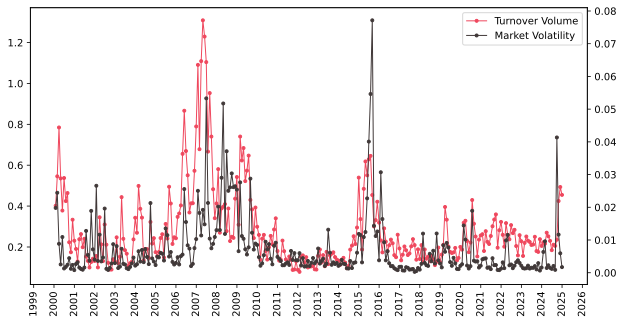

In [92]:
# 季度换手率
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'to_v',
    '.-',
    color = '#EF475D',
    label = 'Turnover Volume',
    linewidth = 1,
    data = ts_to['2000-01-01':'2024-12-31']
)
# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)

# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())

# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)

# 双y轴
ax2 = ax.twinx()
ax2.plot(
    'mv3',
    '.-',
    color = '#403838',
    label = 'Market Volatility',
    linewidth = 1,
    data = ts_to['2000-01-01':'2024-12-31']
)

# 设置图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show();

## 换手率预测波动率

In [93]:
model1 = smf.ols('mv3 ~ to_v_lag1', data=ts_to['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model2 = smf.ols('mv3 ~ mv3_lag1', data=ts_to['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model3 = smf.ols('mv3 ~ to_v_lag1 + mv3_lag1', data=ts_to['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})

# 创建汇总表格
info_dict_q = {'R-squared': lambda x: f"{x.rsquared:.3f}",
              'No. observations': lambda x: f"{int(x.nobs)}"}

results_table = summary_col(
    results=[model1, model2, model3],
    float_format='%0.3f',  # 数据显示格式，3位小数
    stars=True,  # 显示显著性星号
    model_names=['ToV', 'MV3', 'ToV+MV3'],
    info_dict=info_dict_q,
    regressor_order=['Intercept', 'to_v_lag1', 'mv3_lag1']
)

results_table.add_title('Table - 季度OLS回归: 换手率和波动率预测未来波动率')
print(results_table)


      Table - 季度OLS回归: 换手率和波动率预测未来波动率
                   ToV      MV3    ToV+MV3 
-------------------------------------------
Intercept        0.003**  0.007*** 0.003*  
                 (0.001)  (0.002)  (0.001) 
to_v_lag1        0.019***          0.017***
                 (0.003)           (0.004) 
mv3_lag1                  0.198*   0.098   
                          (0.110)  (0.089) 
R-squared        0.089    0.039    0.097   
R-squared Adj.   0.086    0.037    0.092   
No. observations 359      359      359     
R-squared        0.089    0.039    0.097   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [94]:
# 使用model3的拟合值当做conditional variance的度量预测收益率
ts_to['mv3_fit'] = model3.fittedvalues

model = smf.ols('ret ~ mv3_fit', data=ts_to['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model2 = smf.ols('ret ~ pd_lag1', data=ts_to['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})
model3 = smf.ols('ret ~ mv3_fit + pd_lag1', data=ts_to['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6})

info_dict_q = {'R-squared': lambda x: f"{x.rsquared:.3f}",
              'No. observations': lambda x: f"{int(x.nobs)}"}

results_table_q = summary_col(
    results=[model, model2, model3],
    float_format='%0.3f',  # 数据显示格式，3位小数
    stars=True,  # 显示显著性星号
    model_names=['MV3', 'PD', 'MV3+PD'],
    info_dict=info_dict_q,
    regressor_order=['Intercept', 'mv3_fit', 'pd_lag1']
)

results_table_q.add_title('Table - 季度OLS回归: 换手率和波动率预测未来收益率')
print(results_table_q)

    Table - 季度OLS回归: 换手率和波动率预测未来收益率
                   MV3      PD    MV3+PD
----------------------------------------
Intercept        -0.009  0.038   0.046  
                 (0.009) (0.030) (0.029)
mv3_fit          2.077*          2.594**
                 (1.178)         (1.293)
pd_lag1                  -0.007  -0.014*
                         (0.007) (0.007)
R-squared        0.017   0.002   0.026  
R-squared Adj.   0.014   -0.001  0.020  
No. observations 359     359     359    
R-squared        0.017   0.002   0.026  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# IPO数量 IPON 

In [95]:
IPO = pd.read_csv('Data/QX_IPO.csv')
IPO

,Symbol,ListedDate,ListedYear,ABSymbol,HSymbol,EstablishDate,IpoDate,CompanyListedDate,IsIPO,TotalShares,IssuePrice,CurrencyCode,ClosePrice,ReturnRate,TurnoverRate1,TurnoverRate2,PE,PB
0,1,1991-04-03,1991,NaN,NaN,1987-12-22,1989-03-10,1991-04-03,A,350000.0,40.00,CNY,49.00,0.225000,0.00000,0.00000,NaN,NaN
1,2,1991-01-29,1991,NaN,2202.0,1984-05-30,1988-12-28,1991-01-29,A,28000000.0,1.00,CNY,14.58,13.580000,0.00004,0.00005,NaN,NaN
2,3,1991-07-03,1991,NaN,NaN,1988-11-09,1989-02-28,1991-07-03,A,42716330.0,10.00,CNY,6.30,-0.370000,0.00303,0.00536,NaN,NaN
3,4,1991-01-14,1991,NaN,NaN,1986-05-05,1989-12-23,1991-01-14,A,12500000.0,1.00,CNY,15.98,14.980000,0.00004,0.00010,NaN,NaN
4,5,1990-12-10,1990,NaN,NaN,1987-07-23,1990-03-03,1990-12-10,A,44338500.0,10.00,CNY,18.03,0.803000,NaN,NaN,NaN,24.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5580,920108,2025-02-06,2025,NaN,NaN,2005-02-22,2025-01-17,2025-02-06,A,23000000.0,5.57,CNY,19.28,2.461400,0.16992,0.87559,NaN,NaN
5581,920111,2024-11-11,2024,NaN,NaN,1996-11-08,2024-10-29,2024-11-11,A,44654500.0,6.25,CNY,23.77,2.803200,0.22468,0.90953,46.24,7.31
5582,920116,2025-01-02,2025,NaN,NaN,2016-12-14,2024-12-24,2025-01-02,A,31625000.0,6.92,CNY,35.10,4.072254,0.20263,0.85319,NaN,NaN
5583,920118,2024-08-22,2024,NaN,NaN,2004-02-19,2024-08-13,2024-08-22,A,8395000.0,17.00,CNY,23.13,0.360588,0.15710,0.55644,15.20,2.82


In [96]:
IPO['month'] = pd.to_datetime(IPO['ListedDate'],format='%Y-%m-%d').dt.to_period('M')
IPO['Symbol'] = IPO['Symbol'].astype(str).str.zfill(6)
IPO = IPO[(IPO['Symbol'].str.startswith('0') | 
           IPO['Symbol'].str.startswith('3') | 
           IPO['Symbol'].str.startswith('6')) & 
          ~(IPO['Symbol'].str.startswith('688') | 
            IPO['Symbol'].str.startswith('689'))]
IPO

,Symbol,ListedDate,ListedYear,ABSymbol,HSymbol,EstablishDate,IpoDate,CompanyListedDate,IsIPO,TotalShares,IssuePrice,CurrencyCode,ClosePrice,ReturnRate,TurnoverRate1,TurnoverRate2,PE,PB,month
0,000001,1991-04-03,1991,NaN,NaN,1987-12-22,1989-03-10,1991-04-03,A,350000.0,40.00,CNY,49.00,0.225000,0.00000,0.00000,NaN,NaN,1991-04
1,000002,1991-01-29,1991,NaN,2202.0,1984-05-30,1988-12-28,1991-01-29,A,28000000.0,1.00,CNY,14.58,13.580000,0.00004,0.00005,NaN,NaN,1991-01
2,000003,1991-07-03,1991,NaN,NaN,1988-11-09,1989-02-28,1991-07-03,A,42716330.0,10.00,CNY,6.30,-0.370000,0.00303,0.00536,NaN,NaN,1991-07
3,000004,1991-01-14,1991,NaN,NaN,1986-05-05,1989-12-23,1991-01-14,A,12500000.0,1.00,CNY,15.98,14.980000,0.00004,0.00010,NaN,NaN,1991-01
4,000005,1990-12-10,1990,NaN,NaN,1987-07-23,1990-03-03,1990-12-10,A,44338500.0,10.00,CNY,18.03,0.803000,NaN,NaN,NaN,24.66,1990-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,605580,2021-08-19,2021,NaN,NaN,2007-03-05,2021-08-09,2021-08-19,A,50000000.0,8.38,CNY,12.07,0.440334,0.00208,0.00833,22.10,6.74,2021-08
4918,605588,2021-08-12,2021,NaN,NaN,2002-01-18,2021-07-30,2021-08-12,A,18275000.0,27.42,CNY,39.48,0.439825,0.00156,0.00623,31.80,7.68,2021-08
4919,605589,2021-08-10,2021,NaN,NaN,1994-01-24,2021-07-29,2021-08-10,A,81060000.0,24.01,CNY,34.57,0.439817,0.00140,0.01338,30.53,4.78,2021-08
4920,605598,2021-09-17,2021,NaN,NaN,2000-01-28,2021-09-08,2021-09-17,A,43193467.0,13.87,CNY,19.97,0.439798,0.00592,0.02367,31.82,4.08,2021-09


In [97]:
# 按月统计IPO数量
IPO_count = IPO.groupby('month').size()
IPO_count = IPO_count.to_frame(name='IPON')
IPO_count.index = IPO_count.index.asfreq('M').to_timestamp('M')

# 将索引转换为datetime以便后续处理
# IPO_count.index = IPO_count.index.to_timestamp()
IPO_count

,IPON
month,
1990-12-31,8
1991-01-31,2
1991-04-30,1
1991-06-30,1
1991-07-31,1
...,...
2024-11-30,4
2024-12-31,6
2025-01-31,7


In [98]:
# 创建完整的时间序列从1990年1月到2024年12月
# 创建月末日期范围
full_date_range = pd.date_range(start='1995-01-31', end='2024-12-31', freq='ME')
# name 为month
full_date_range.name = 'month'

# 创建一个包含所有月份的DataFrame，使用月末日期作为索引
full_IPO_count = pd.DataFrame(index=full_date_range, columns=['IPOn'])
IPO_count = IPO_count.merge(full_IPO_count,on='month', how='right')
IPO_count = IPO_count[['IPON']].fillna(0)
IPO_count 


,IPON
month,
1995-01-31,1.0
1995-02-28,3.0
1995-03-31,3.0
1995-04-30,1.0
1995-05-31,0.0
...,...
2024-08-31,6.0
2024-09-30,6.0
2024-10-31,7.0


In [99]:
ts_ipon = ts_to.merge(IPO_count, on='month', how='left')
ts_ipon

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us,ret_us_lag1,ret_lag1,pd,pd_lag1,ret_1m,ret_3m,ret_6m,ret_12m,ret_24m,ret_36m,ret_48m,ret_60m,mv,mv1,mv2,mv3,mv4,mv_lag1,mv1_lag1,mv2_lag1,mv3_lag1,mv4_lag1,to_v,to_m,to_v_lag1,to_m_lag1,mv3_fit,IPON
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-01-31,-0.116298,-0.125837,7.195238e+07,0.008719,-0.125017,-0.134556,0.0180,0.0086,-0.063907,4.084782,NaN,-0.022778,-0.013638,0.118028,-0.116804,0.849761,1.072520,0.969609,1.346000,0.005917,0.005917,0.009039,0.010699,0.010699,NaN,NaN,NaN,NaN,NaN,0.083688,0.097849,NaN,NaN,NaN,1.0
1995-02-28,-0.014059,-0.013693,7.170322e+07,0.008719,-0.022778,-0.022412,0.0363,0.0180,-0.125017,4.081370,4.084782,0.122163,0.175876,0.181846,-0.068728,0.924521,1.067777,0.946063,1.488946,0.018659,0.018659,0.018659,0.018659,0.018659,0.005917,0.005917,0.009039,0.010699,0.010699,0.092510,0.112872,0.083688,0.097849,0.005047,3.0
1995-03-31,0.130882,0.146959,8.217532e+07,0.008719,0.122163,0.138240,0.0219,0.0363,-0.022778,4.238190,4.081370,-0.113023,-0.041028,0.045422,-0.191401,1.001870,0.962820,0.885519,1.420853,0.010824,0.016590,0.016590,0.016590,0.016590,0.018659,0.018659,0.018659,0.018659,0.018659,0.297878,0.395946,0.092510,0.112872,0.005972,3.0
1995-04-30,-0.104304,-0.101424,7.431161e+07,0.008719,-0.113023,-0.110143,0.0211,0.0219,0.122163,4.117053,4.238190,0.166736,0.131666,0.159207,0.251999,1.231923,1.161154,0.959536,1.545034,0.007637,0.009507,0.009507,0.009507,0.011160,0.010824,0.016590,0.016590,0.016590,0.016590,0.268714,0.329273,0.297878,0.395946,0.009208,1.0
1995-05-31,0.175455,0.199416,8.732088e+07,0.008719,0.166736,0.190697,0.0290,0.0211,-0.113023,4.185583,4.117053,-0.094741,0.005970,-0.099054,0.072163,0.972245,1.044637,0.905517,1.404133,0.149315,0.218157,0.228720,0.228720,0.228720,0.007637,0.009507,0.009507,0.009507,0.011160,0.592373,0.727932,0.268714,0.329273,0.008028,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,6.000512e+10,0.001118,-0.032586,-0.034803,0.0161,0.0124,-0.000624,3.593815,3.640346,0.194874,0.198953,NaN,NaN,NaN,NaN,NaN,NaN,0.000881,0.000881,0.000881,0.000881,0.000881,0.001878,0.001878,0.002073,0.002073,0.002073,0.205272,0.203924,0.211110,0.225505,0.006338,6.0
2024-09-30,0.195992,0.227078,7.182264e+10,0.001118,0.194874,0.225960,0.0174,0.0161,-0.032586,3.754717,3.593815,-0.004527,0.000282,NaN,NaN,NaN,NaN,NaN,NaN,0.012481,0.023868,0.034838,0.041347,0.049594,0.000881,0.000881,0.000881,0.000881,0.000881,0.235540,0.231543,0.205272,0.203924,0.006124,6.0
2024-10-31,-0.003409,0.070220,7.162078e+10,0.001118,-0.004527,0.069102,-0.0097,0.0174,0.194874,3.726254,3.754717,0.008606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011652,0.011652,0.011652,0.011652,0.011652,0.012481,0.023868,0.034838,0.041347,0.049594,0.424766,0.464635,0.235540,0.231543,0.010582,7.0


## IPO数量：图

### IPON和收益率

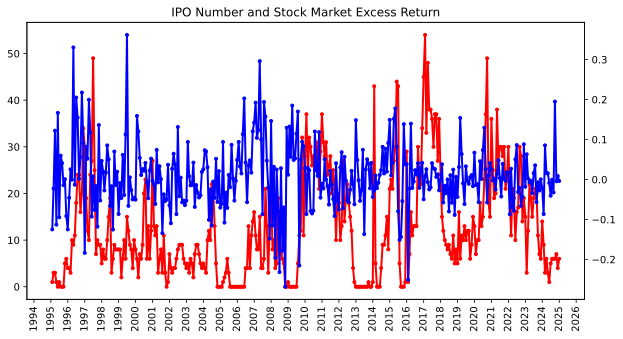

In [100]:
# plot ret pd
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'IPON',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'Return',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_ipon)  # 画图的数据
# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(
    'ret',  # 要画图的变量名
    '.-b',  # 线的类型
    label = 'Return',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_ipon)  # 画图的数据

plt.title('IPO Number and Stock Market Excess Return')

plt.show();


### IPON和Price Ratio

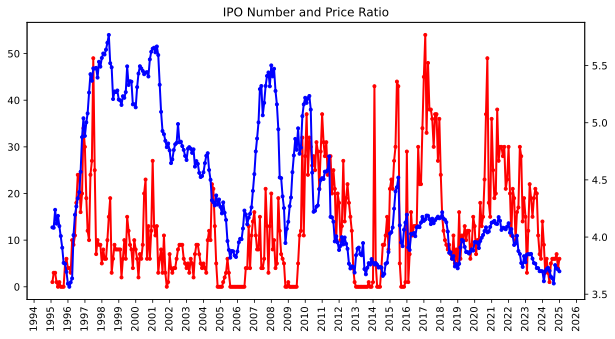

In [101]:
# plot pd and IPON
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'IPON',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'IPON',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_ipon)  # 画图的数据
# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)


ax2 = ax.twinx()
ax2.plot(
    'pd',  # 要画图的变量名
    '.-b',  # 线的类型
    label = 'Price Ratio',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_ipon)  # 画图的数据

plt.title('IPO Number and Price Ratio')

plt.show();


## 回归预测

In [102]:
ts_ipon['IPON_lag1'] = ts_ipon['IPON'].shift(1)

model1 = smf.ols('ret ~ IPON_lag1', data=ts_ipon['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC',cov_kwds={'maxlags': 6})
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     5.610
Date:                Fri, 16 May 2025   Prob (F-statistic):             0.0184
Time:                        10:53:40   Log-Likelihood:                 392.18
No. Observations:                 359   AIC:                            -780.4
Df Residuals:                     357   BIC:                            -772.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0182      0.007      2.488      0.0

In [103]:
model2 = smf.ols('ret ~ IPON_lag1 + mv3_lag1',data = ts_ipon['1995':'2024']).fit(
    cov_type='HAC',cov_kwds={'maxlags':2}
)
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.716
Date:                Fri, 16 May 2025   Prob (F-statistic):             0.0675
Time:                        10:53:41   Log-Likelihood:                 392.21
No. Observations:                 359   AIC:                            -778.4
Df Residuals:                     356   BIC:                            -766.8
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0188      0.007      2.675      0.0

# 投资者情绪：新增开户数

In [106]:
CICSI = pd.read_excel('Data/QX_CICSI.xlsx')
CICSI

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,SgnMonth,DCEF,TURN,IPON,IPOR,NIA,CCI,CICSI,StdCICSI,StdExMacroCICSI
0,统计月度,基金折价率(%),上月交易量,IPO个数,IPO首日收益,上月新增投资者开户数,消费者信心指数,投资者情绪指数,投资者情绪指数(标准化),投资者情绪指数(标准化-剔除宏观经济因素)
1,没有单位,没有单位,没有单位,个,没有单位,没有单位,没有单位,没有单位,NaN,NaN
2,2003-02,-12.8895,0.1815,3,4.6707,11.69,97.8,30.28,-1.39,-1.42
3,2003-03,-17.0693,0.0943,6,4.7492,11.36,97.6,29.91,-1.72,-1.82
4,2003-04,-20.2471,0.1231,5,4.4182,11.49,88.7,26.48,-1.92,-1.99
...,...,...,...,...,...,...,...,...,...,...
245,2023-05,-0.0474,0.2578,31,3.5379,13.82,88.2,38.39,0.04,0.08
246,2023-06,-0.0179,0.2233,39,4.6433,13.79,86.4,40.3,0.1,0.12
247,2023-07,-0.048,0.233,37,10.4896,13.8,86.4,41.67,0.36,0.38
248,2023-08,0.0808,0.2141,33,9.7781,13.72,86.5,40.44,0.2,0.2


In [107]:
CICSI = CICSI.iloc[2:].set_index('SgnMonth')
CICSI.index.name = 'month'
CICSI

,DCEF,TURN,IPON,IPOR,NIA,CCI,CICSI,StdCICSI,StdExMacroCICSI
month,,,,,,,,,
2003-02,-12.8895,0.1815,3,4.6707,11.69,97.8,30.28,-1.39,-1.42
2003-03,-17.0693,0.0943,6,4.7492,11.36,97.6,29.91,-1.72,-1.82
2003-04,-20.2471,0.1231,5,4.4182,11.49,88.7,26.48,-1.92,-1.99
2003-05,-21.0241,0.3241,2,8.4551,12.05,85.7,26.3,-1.27,-1.16
2003-06,-15.9344,0.1821,7,4.5799,11.75,88.6,28.14,-1.58,-1.59
...,...,...,...,...,...,...,...,...,...
2023-05,-0.0474,0.2578,31,3.5379,13.82,88.2,38.39,0.04,0.08
2023-06,-0.0179,0.2233,39,4.6433,13.79,86.4,40.3,0.1,0.12
2023-07,-0.048,0.233,37,10.4896,13.8,86.4,41.67,0.36,0.38


In [109]:
# 删除第一行第二行 并选择SgnMonth和NIA
NIA = CICSI.loc[:,['NIA']]
# index重命名成month
NIA.index.name = 'month'
# 将NIA的index转换为datetime 并且是月末 再减一个月
NIA.index = pd.to_datetime(NIA.index)
NIA.index = NIA.index + pd.offsets.MonthEnd(0)
NIA.index = NIA.index - pd.offsets.MonthEnd(1)
NIA['NIA'] = NIA['NIA'].astype(float)
NIA



,NIA
month,
2003-01-31,11.69
2003-02-28,11.36
2003-03-31,11.49
2003-04-30,12.05
2003-05-31,11.75
...,...
2023-04-30,13.82
2023-05-31,13.79
2023-06-30,13.80


In [ ]:
# merge data
ts_nia = ts_ipon.merge(NIA, on='month', how='right')
ts_nia

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us,ret_us_lag1,ret_lag1,pd,pd_lag1,ret_1m,ret_3m,ret_6m,ret_12m,ret_24m,ret_36m,ret_48m,ret_60m,mv,mv1,mv2,mv3,mv4,mv_lag1,mv1_lag1,mv2_lag1,mv3_lag1,mv4_lag1,to_v,to_m,to_v_lag1,to_m_lag1,mv3_fit,IPON,IPON_lag1,NIA
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-31,0.095492,0.102435,1.294347e+09,0.001635,0.093857,0.100800,-0.0257,-0.0576,-0.053127,4.773539,4.673774,0.008075,-0.020381,-0.060598,-0.060164,-0.366099,-0.316144,0.587623,1.386194,0.005656,0.005656,0.007238,0.008127,0.010362,0.002945,0.002945,0.002945,0.002945,0.002945,0.247118,0.226939,0.129797,0.136410,0.005061,5.0,4.0,11.69
2003-02-28,0.009710,0.014786,1.309596e+09,0.001635,0.008075,0.013151,-0.0188,-0.0257,0.093857,4.786243,4.773539,-0.014767,0.013814,-0.101397,0.001599,-0.280246,-0.291670,0.683624,1.409916,0.001429,0.001429,0.001429,0.001429,0.001429,0.005656,0.005656,0.007238,0.008127,0.010362,0.120652,0.120720,0.247118,0.226939,0.007532,3.0,5.0,11.36
2003-03-31,-0.013132,-0.025631,1.294983e+09,0.001635,-0.014767,-0.027266,0.0109,-0.0188,0.008075,4.772871,4.786243,-0.013689,-0.039959,-0.131654,0.047065,-0.373386,-0.261870,0.821925,1.228737,0.001772,0.001772,0.001772,0.001867,0.002112,0.001429,0.001429,0.001429,0.001429,0.001429,0.152374,0.158612,0.120652,0.120720,0.004760,6.0,3.0,11.49
2003-04-30,-0.012054,-0.042101,1.298238e+09,0.001635,-0.013689,-0.043736,0.0822,0.0109,-0.014767,4.735928,4.772871,0.042270,-0.040217,-0.157480,-0.040190,-0.392422,-0.135041,1.131656,1.267295,0.003983,0.004949,0.004949,0.007314,0.007426,0.001772,0.001772,0.001772,0.001867,0.002112,0.443804,0.424915,0.152374,0.158612,0.005334,5.0,6.0,12.05
2003-05-31,0.043905,0.040771,1.348684e+09,0.001635,0.042270,0.039136,0.0605,0.0822,-0.013689,4.767142,4.735928,-0.068540,-0.115211,-0.180649,-0.107032,-0.505839,0.025429,1.189394,1.145149,0.002733,0.002733,0.002733,0.002733,0.002733,0.003983,0.004949,0.004949,0.007314,0.007426,0.239915,0.240415,0.443804,0.424915,0.010746,2.0,5.0,11.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,-0.001596,-0.029947,6.842106e+10,0.001365,-0.002961,-0.031312,0.0061,0.0251,-0.007046,3.852932,3.849071,-0.034308,0.017052,-0.074459,-0.065398,NaN,NaN,NaN,NaN,0.001040,0.001749,0.002172,0.002172,0.002172,0.001156,0.001156,0.001385,0.001385,0.001385,0.230993,0.284345,0.251266,0.289871,0.006943,19.0,22.0,13.82
2023-05-31,-0.032943,0.000391,6.623780e+10,0.001365,-0.034308,-0.000974,0.0035,0.0061,-0.002961,3.811356,3.852932,0.015956,-0.005575,-0.039644,-0.039661,NaN,NaN,NaN,NaN,0.001118,0.001118,0.001118,0.001273,0.001273,0.001040,0.001749,0.002172,0.002172,0.002172,0.224640,0.252732,0.230993,0.284345,0.006680,15.0,19.0,13.79
2023-06-30,0.017321,0.024932,6.740856e+10,0.001365,0.015956,0.023567,0.0647,0.0035,-0.034308,3.772458,3.811356,0.035404,-0.028503,-0.076886,-0.096316,NaN,NaN,NaN,NaN,0.001218,0.001539,0.001539,0.001539,0.001539,0.001118,0.001118,0.001118,0.001273,0.001273,0.209992,0.261728,0.224640,0.252732,0.006486,19.0,15.0,13.80


## NIA、IPON和Price Ratio 图

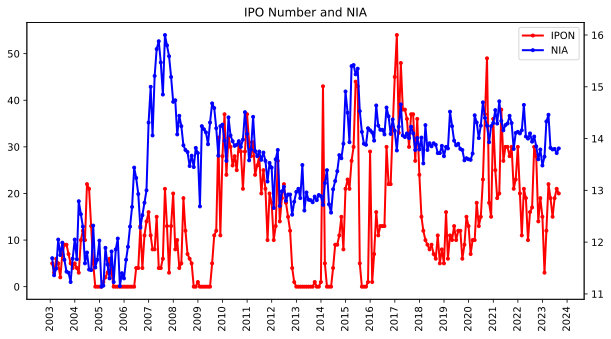

In [111]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'IPON',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'IPON',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_nia)  # 画图的数据
# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(
    'NIA',  # 要画图的变量名
    '.-b',  # 线的类型
    label = 'NIA',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_nia)  # 画图的数据

plt.title('IPO Number and NIA')

# 两条线的图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show();

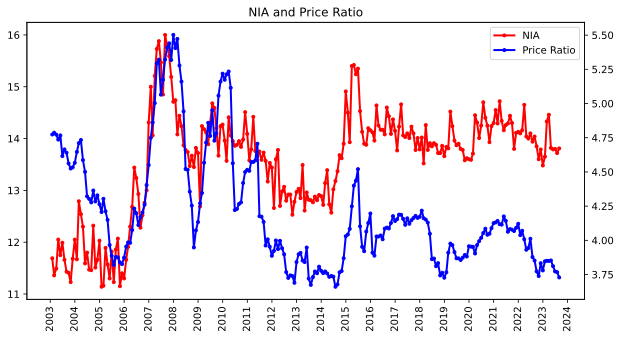

In [105]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'NIA',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'NIA',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_nia)  # 画图的数据
# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(
    'pd',  # 要画图的变量名
    '.-b',  # 线的类型
    label = 'Price Ratio',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_nia)  # 画图的数据

plt.title('NIA and Price Ratio')
# 两条线的图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show();

In [106]:
# NIA 回归到时间趋势上
# 给数据添加时间趋势
ts_nia['month_trend'] = np.arange(len(ts_nia)) + 1
ts_nia['month_trend_square'] = ts_nia['month_trend']**2


In [107]:
model1 = smf.ols('NIA ~ month_trend + month_trend_square', data=ts_nia['2003-01-01':'2023-08-31']).fit(
    cov_type='HAC',cov_kwds={'maxlags': 6})
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    NIA   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     16.98
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.24e-07
Time:                        15:16:59   Log-Likelihood:                -298.01
No. Observations:                 248   AIC:                             602.0
Df Residuals:                     245   BIC:                             612.6
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.8544      0

In [109]:
ts_nia['NIA_res'] = model1.resid
ts_nia

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e,ret_us,ret_us_lag1,ret_lag1,pd,pd_lag1,ret_1m,ret_3m,ret_6m,ret_12m,ret_24m,ret_36m,ret_48m,ret_60m,mv,mv1,mv2,mv3,mv4,mv_lag1,mv1_lag1,mv2_lag1,mv3_lag1,mv4_lag1,to_v,to_m,to_v_lag1,to_m_lag1,mv3_fit,IPON,IPON_lag1,NIA,month_trend,month_trend_square,NIA_fit,NIA_res
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-31,0.095492,0.102435,1.294347e+09,0.001635,0.093857,0.100800,-0.0257,-0.0576,-0.053127,4.773539,4.673774,0.008075,-0.020381,-0.060598,-0.060164,-0.366099,-0.316144,0.587623,1.386194,0.005656,0.005656,0.007238,0.008127,0.010362,0.002945,0.002945,0.002945,0.002945,0.002945,0.247118,0.226939,0.129797,0.136410,0.005061,5.0,4.0,11.69,1,1,-0.190433,-0.190433
2003-02-28,0.009710,0.014786,1.309596e+09,0.001635,0.008075,0.013151,-0.0188,-0.0257,0.093857,4.786243,4.773539,-0.014767,0.013814,-0.101397,0.001599,-0.280246,-0.291670,0.683624,1.409916,0.001429,0.001429,0.001429,0.001429,0.001429,0.005656,0.005656,0.007238,0.008127,0.010362,0.120652,0.120720,0.247118,0.226939,0.007532,3.0,5.0,11.36,2,4,-0.546364,-0.546364
2003-03-31,-0.013132,-0.025631,1.294983e+09,0.001635,-0.014767,-0.027266,0.0109,-0.0188,0.008075,4.772871,4.786243,-0.013689,-0.039959,-0.131654,0.047065,-0.373386,-0.261870,0.821925,1.228737,0.001772,0.001772,0.001772,0.001867,0.002112,0.001429,0.001429,0.001429,0.001429,0.001429,0.152374,0.158612,0.120652,0.120720,0.004760,6.0,3.0,11.49,3,9,-0.442145,-0.442145
2003-04-30,-0.012054,-0.042101,1.298238e+09,0.001635,-0.013689,-0.043736,0.0822,0.0109,-0.014767,4.735928,4.772871,0.042270,-0.040217,-0.157480,-0.040190,-0.392422,-0.135041,1.131656,1.267295,0.003983,0.004949,0.004949,0.007314,0.007426,0.001772,0.001772,0.001772,0.001867,0.002112,0.443804,0.424915,0.152374,0.158612,0.005334,5.0,6.0,12.05,4,16,0.092225,0.092225
2003-05-31,0.043905,0.040771,1.348684e+09,0.001635,0.042270,0.039136,0.0605,0.0822,-0.013689,4.767142,4.735928,-0.068540,-0.115211,-0.180649,-0.107032,-0.505839,0.025429,1.189394,1.145149,0.002733,0.002733,0.002733,0.002733,0.002733,0.003983,0.004949,0.004949,0.007314,0.007426,0.239915,0.240415,0.443804,0.424915,0.010746,2.0,5.0,11.75,5,25,-0.233256,-0.233256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,-0.001596,-0.029947,6.842106e+10,0.001365,-0.002961,-0.031312,0.0061,0.0251,-0.007046,3.852932,3.849071,-0.034308,0.017052,-0.074459,-0.065398,NaN,NaN,NaN,NaN,0.001040,0.001749,0.002172,0.002172,0.002172,0.001156,0.001156,0.001385,0.001385,0.001385,0.230993,0.284345,0.251266,0.289871,0.006943,19.0,22.0,13.82,244,59536,0.047202,0.047202
2023-05-31,-0.032943,0.000391,6.623780e+10,0.001365,-0.034308,-0.000974,0.0035,0.0061,-0.002961,3.811356,3.852932,0.015956,-0.005575,-0.039644,-0.039661,NaN,NaN,NaN,NaN,0.001118,0.001118,0.001118,0.001273,0.001273,0.001040,0.001749,0.002172,0.002172,0.002172,0.224640,0.252732,0.230993,0.284345,0.006680,15.0,19.0,13.79,245,60025,0.027707,0.027707
2023-06-30,0.017321,0.024932,6.740856e+10,0.001365,0.015956,0.023567,0.0647,0.0035,-0.034308,3.772458,3.811356,0.035404,-0.028503,-0.076886,-0.096316,NaN,NaN,NaN,NaN,0.001218,0.001539,0.001539,0.001539,0.001539,0.001118,0.001118,0.001118,0.001273,0.001273,0.209992,0.261728,0.224640,0.252732,0.006486,19.0,15.0,13.80,246,60516,0.048363,0.048363


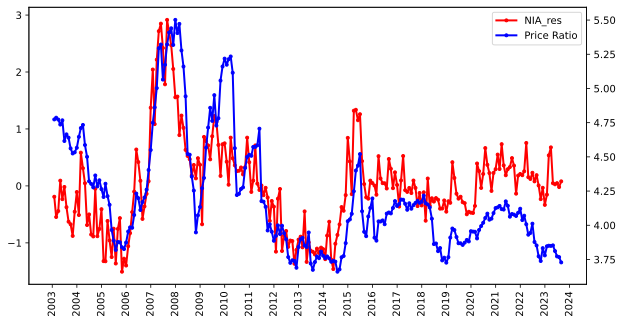

In [110]:

# 画出NIA和NIA_fit的图
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'NIA_res',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'NIA_res',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_nia['2003-01-01':'2023-08-31'])  # 画图的数据
# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(
    'pd',  # 要画图的变量名
    '.-b',  # 线的类型
    label = 'Price Ratio',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts_nia['2003-01-01':'2023-08-31'])  # 画图的数据

# 两条线的图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show();


## 回归预测

In [111]:
ts_nia['NIA_res_lag1'] = ts_nia['NIA_res'].shift(1)

# mv3 fit
model_mv3 = smf.ols('mv3 ~ to_v_lag1 + mv3_lag1', data=ts_nia['2003-01-01':'2023-08-31']).fit(
    cov_type='HAC',cov_kwds={'maxlags': 6})
ts_nia['mv3_fit'] = model_mv3.fittedvalues

model1 = smf.ols('ret ~ NIA_res_lag1', data=ts_nia['2003-01-01':'2023-08-31']).fit(
    cov_type='HAC',cov_kwds={'maxlags': 6})
model2 = smf.ols('ret ~ NIA_res_lag1 + mv3_fit', data=ts_nia['2003-01-01':'2023-08-31']).fit(
    cov_type='HAC',cov_kwds={'maxlags': 6})

info_dict_q = {'R-squared': lambda x: f"{x.rsquared:.3f}",
              'No. observations': lambda x: f"{int(x.nobs)}"}

results_table_q = summary_col(
    results=[model1, model2],
    float_format='%0.3f',  # 数据显示格式，3位小数
    stars=True,  # 显示显著性星号
    model_names=['NIA', 'NIA+MV3'],
    info_dict=info_dict_q,
    regressor_order=['Intercept', 'NIA_fit', 'mv3_lag1']
)

results_table_q.add_title('Table - 季度OLS回归: NIA和Price Ratio预测收益率')
print(results_table_q)


Table - 季度OLS回归: NIA和Price Ratio预测收益率
                   NIA   NIA+MV3
--------------------------------
Intercept        0.007   0.003  
                 (0.006) (0.012)
NIA_res_lag1     0.006   0.003  
                 (0.010) (0.009)
mv3_fit                  0.646  
                         (1.873)
R-squared        0.004   0.005  
R-squared Adj.   -0.001  -0.003 
No. observations 247     247    
R-squared        0.004   0.005  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# 季度结果

In [112]:
from pandas.tseries.offsets import QuarterEnd
Marketret_day_stock['Quarter'] = Marketret_day_stock['Day'].dt.to_period('Q').dt.to_timestamp(freq='Q')
Marketret_day_stock

,Day,MarketR,MarketR_e,month,rfday,er,er1,er2,er3,er4,Quarter
0,1990-12-20,0.050067,0.752547,1990-12-31,0.000227,0.049840,NaN,NaN,NaN,NaN,1990-12-31
1,1990-12-21,0.039671,67.771445,1990-12-31,0.000227,0.039444,0.049840,NaN,NaN,NaN,1990-12-31
2,1990-12-24,0.049380,0.049638,1990-12-31,0.000227,0.049153,0.039444,0.049840,NaN,NaN,1990-12-31
3,1990-12-25,0.049938,0.050022,1990-12-31,0.000227,0.049711,0.049153,0.039444,0.049840,NaN,1990-12-31
4,1990-12-26,0.050151,0.050151,1990-12-31,0.000227,0.049924,0.049711,0.049153,0.039444,0.049840,1990-12-31
...,...,...,...,...,...,...,...,...,...,...,...
8356,2024-12-25,-0.004361,-0.019226,2024-12-31,0.000037,-0.004398,0.012003,-0.009967,-0.000314,-0.001943,2024-12-31
8357,2024-12-26,0.002969,0.011729,2024-12-31,0.000037,0.002932,-0.004398,0.012003,-0.009967,-0.000314,2024-12-31
8358,2024-12-27,0.002119,0.008489,2024-12-31,0.000037,0.002082,0.002932,-0.004398,0.012003,-0.009967,2024-12-31
8359,2024-12-30,0.000660,-0.008647,2024-12-31,0.000037,0.000623,0.002082,0.002932,-0.004398,0.012003,2024-12-31


In [113]:
# 按月分组计算方差
Marketvariance_qtr_stock = (Marketret_day_stock
                           .groupby('Quarter', group_keys=False)
                           .apply(calc_variance,include_groups=False)
                           .apply(pd.Series)  # 直接转换为DataFrame
                           .reset_index())

# 设置月份为索引
Marketvariance_qtr_stock.set_index('Quarter', inplace=True)

# 处理负方差 - 使用列表循环简化逻辑
variance_cols = ['mv', 'mv1', 'mv2', 'mv3', 'mv4']
for i in range(1, 5):
    Marketvariance_qtr_stock[f'mv{i}'] = np.maximum(
        Marketvariance_qtr_stock[f'mv{i}'],
        Marketvariance_qtr_stock[variance_cols[i-1]]  # 如果为负则使用前一阶方差
    )

# 显示结果
Marketvariance_qtr_stock

,mv,mv1,mv2,mv3,mv4
Quarter,,,,,
1990-12-31,0.011709,NaN,NaN,NaN,NaN
1991-03-31,0.002337,0.005198,0.008096,0.010593,0.013833
1991-06-30,0.006177,0.008025,0.008207,0.010588,0.011993
1991-09-30,0.119336,0.119336,0.119336,0.119336,0.119336
1991-12-31,0.155513,0.176020,0.199149,0.234951,0.278422
...,...,...,...,...,...
2023-12-31,0.003146,0.004187,0.004378,0.004791,0.004791
2024-03-31,0.009678,0.012825,0.014335,0.014335,0.014335
2024-06-30,0.004243,0.004243,0.004243,0.004243,0.004243


In [114]:
# 月度数据重新整理成季度
# 季度收益率使用月度复合收益率
# mv使用sum
# pd使用季度里的最后一个观测值

ts_q = ts_ipon.resample('QE').apply({
    'ret':
    lambda x: np.prod(1 + x) - 1,
    'pd':
    lambda x: x.iloc[-1],
    'IPON':
    lambda x: np.mean(x),
    'to_v':
    lambda x: sum(x)
})
ts_q.index.name = 'Quarter'
ts_q = ts_q.merge(Marketvariance_qtr_stock, on='Quarter', how='left')
ts_q['pd_lag1'] = ts_q['pd'].shift(1)
ts_q['mv3_lag1'] = ts_q['mv3'].shift(1)
ts_q['IPON_lag1'] = ts_q['IPON'].shift(1)
ts_q['to_v_lag1'] = ts_q['to_v'].shift(1)
ts_q

,ret,pd,IPON,to_v,mv,mv1,mv2,mv3,mv4,pd_lag1,mv3_lag1,IPON_lag1,to_v_lag1
Quarter,,,,,,,,,,,,,
1995-03-31,-0.040492,4.238190,2.333333,0.474076,0.035401,0.036770,0.036770,0.036770,0.036770,NaN,NaN,NaN,NaN
1995-06-30,-0.063176,4.095985,0.666667,1.082062,0.165481,0.233823,0.240724,0.240724,0.240724,4.238190,0.036770,2.333333,0.474076
1995-09-30,0.087428,3.773586,0.000000,1.799053,0.018665,0.018665,0.018665,0.018665,0.018665,4.095985,0.240724,0.666667,1.082062
1995-12-31,-0.204470,3.592176,5.000000,0.910139,0.013791,0.013791,0.013791,0.019522,0.019522,3.773586,0.018665,0.000000,1.799053
1996-03-31,-0.022218,3.638418,5.666667,0.427467,0.019166,0.019166,0.019166,0.019166,0.019166,3.592176,0.019522,5.000000,0.910139
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,-0.047820,3.700071,9.000000,0.619288,0.003146,0.004187,0.004378,0.004791,0.004791,3.728018,0.004229,17.333333,0.641921
2024-03-31,0.006789,3.719650,6.000000,0.708789,0.009678,0.012825,0.014335,0.014335,0.014335,3.700071,0.004791,9.000000,0.619288
2024-06-30,-0.034157,3.653806,3.000000,0.666519,0.004243,0.004243,0.004243,0.004243,0.004243,3.719650,0.014335,6.000000,0.708789


In [115]:
NIA_q = NIA.resample('QE').apply({
    'NIA':
    lambda x: np.mean(x)
})
NIA_q.index.name = 'Quarter'
NIA_q


,NIA
Quarter,
2003-03-31,11.513333
2003-06-30,11.930000
2003-09-30,11.500000
2003-12-31,11.653333
2004-03-31,12.333333
...,...
2022-09-30,13.943333
2022-12-31,13.623333
2023-03-31,14.146667


In [116]:
NIA_q['q_trend'] = np.arange(len(NIA_q)) + 1
NIA_q['q_trend_square'] = NIA_q['q_trend']**2

model_nia = smf.ols('NIA ~ q_trend + q_trend_square', data=NIA_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC',cov_kwds={'maxlags': 6})
NIA_q['NIA_res'] = model_nia.resid
NIA_q

,NIA,q_trend,q_trend_square,NIA_res
Quarter,,,,
2003-03-31,11.513333,1,1,-0.396049
2003-06-30,11.930000,2,4,-0.056124
2003-09-30,11.500000,3,9,-0.561518
2003-12-31,11.653333,4,16,-0.482232
2004-03-31,12.333333,5,25,0.125066
...,...,...,...,...
2022-09-30,13.943333,79,6241,0.091651
2022-12-31,13.623333,80,6400,-0.200064
2023-03-31,14.146667,81,6561,0.352901


In [117]:
ts_q = ts_q.merge(NIA_q, on='Quarter', how='left')
ts_q


,ret,pd,IPON,to_v,mv,mv1,mv2,mv3,mv4,pd_lag1,mv3_lag1,IPON_lag1,to_v_lag1,NIA,q_trend,q_trend_square,NIA_res
Quarter,,,,,,,,,,,,,,,,,
1995-03-31,-0.040492,4.238190,2.333333,0.474076,0.035401,0.036770,0.036770,0.036770,0.036770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-30,-0.063176,4.095985,0.666667,1.082062,0.165481,0.233823,0.240724,0.240724,0.240724,4.238190,0.036770,2.333333,0.474076,NaN,NaN,NaN,NaN
1995-09-30,0.087428,3.773586,0.000000,1.799053,0.018665,0.018665,0.018665,0.018665,0.018665,4.095985,0.240724,0.666667,1.082062,NaN,NaN,NaN,NaN
1995-12-31,-0.204470,3.592176,5.000000,0.910139,0.013791,0.013791,0.013791,0.019522,0.019522,3.773586,0.018665,0.000000,1.799053,NaN,NaN,NaN,NaN
1996-03-31,-0.022218,3.638418,5.666667,0.427467,0.019166,0.019166,0.019166,0.019166,0.019166,3.592176,0.019522,5.000000,0.910139,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,-0.047820,3.700071,9.000000,0.619288,0.003146,0.004187,0.004378,0.004791,0.004791,3.728018,0.004229,17.333333,0.641921,NaN,NaN,NaN,NaN
2024-03-31,0.006789,3.719650,6.000000,0.708789,0.009678,0.012825,0.014335,0.014335,0.014335,3.700071,0.004791,9.000000,0.619288,NaN,NaN,NaN,NaN
2024-06-30,-0.034157,3.653806,3.000000,0.666519,0.004243,0.004243,0.004243,0.004243,0.004243,3.719650,0.014335,6.000000,0.708789,NaN,NaN,NaN,NaN


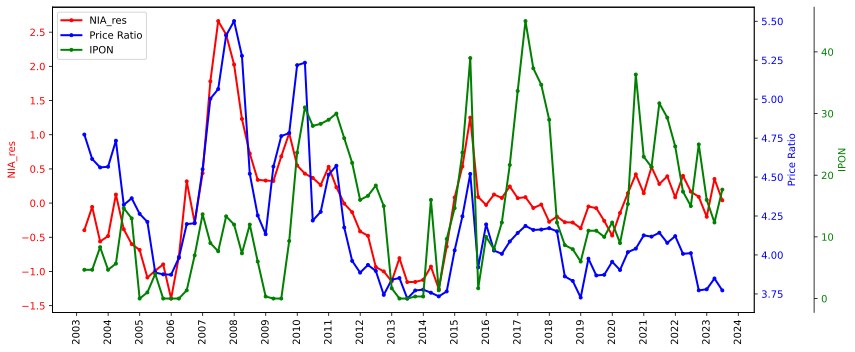

In [118]:
fig, ax = plt.subplots(figsize=(12, 5))

# 第一条线 - 主Y轴
color1 = 'red'
ax.plot('NIA_res', '.-', color=color1, label='NIA_res', linewidth=2, 
        data=ts_q['2003-01-01':'2023-08-31'])
ax.set_ylabel('NIA_res', color=color1)
ax.tick_params(axis='y', labelcolor=color1)
# 设置x轴日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

# 第二条线 - 第二个Y轴
ax2 = ax.twinx()
color2 = 'blue'
ax2.plot('pd', '.-', color=color2, label='Price Ratio', linewidth=2, 
         data=ts_q['2003-01-01':'2023-08-31'])
ax2.set_ylabel('Price Ratio', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# 第三条线 - 第三个Y轴（需要特殊处理）
# 创建位移版的第三个Y轴
ax3 = ax.twinx()
# 将第三个轴向右移动
ax3.spines['right'].set_position(('outward', 60))  # 向外偏移60个点
color3 = 'green'
ax3.plot('IPON', '.-', color=color3, label='IPON', linewidth=2, 
         data=ts_q['2003-01-01':'2023-08-31'])
ax3.set_ylabel('IPON', color=color3)
ax3.tick_params(axis='y', labelcolor=color3)

# 合并所有图例
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')

plt.tight_layout()  # 自动调整布局
plt.show();

In [119]:
model_mv = smf.ols('mv3 ~ mv3_lag1 + to_v_lag1', data=ts_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_mv.summary())

                            OLS Regression Results                            
Dep. Variable:                    mv3   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     7.842
Date:                Fri, 16 May 2025   Prob (F-statistic):           0.000639
Time:                        11:10:37   Log-Likelihood:                 249.70
No. Observations:                 119   AIC:                            -493.4
Df Residuals:                     116   BIC:                            -485.1
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.005      2.184      0.0

In [120]:
ts_q['mv3_fit'] = model_mv.fittedvalues
ts_q


,ret,pd,IPON,to_v,mv,mv1,mv2,mv3,mv4,pd_lag1,mv3_lag1,IPON_lag1,to_v_lag1,NIA,q_trend,q_trend_square,NIA_res,mv3_fit
Quarter,,,,,,,,,,,,,,,,,,
1995-03-31,-0.040492,4.238190,2.333333,0.474076,0.035401,0.036770,0.036770,0.036770,0.036770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-30,-0.063176,4.095985,0.666667,1.082062,0.165481,0.233823,0.240724,0.240724,0.240724,4.238190,0.036770,2.333333,0.474076,NaN,NaN,NaN,NaN,0.020208
1995-09-30,0.087428,3.773586,0.000000,1.799053,0.018665,0.018665,0.018665,0.018665,0.018665,4.095985,0.240724,0.666667,1.082062,NaN,NaN,NaN,NaN,0.054858
1995-12-31,-0.204470,3.592176,5.000000,0.910139,0.013791,0.013791,0.013791,0.019522,0.019522,3.773586,0.018665,0.000000,1.799053,NaN,NaN,NaN,NaN,0.032385
1996-03-31,-0.022218,3.638418,5.666667,0.427467,0.019166,0.019166,0.019166,0.019166,0.019166,3.592176,0.019522,5.000000,0.910139,NaN,NaN,NaN,NaN,0.022670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,-0.047820,3.700071,9.000000,0.619288,0.003146,0.004187,0.004378,0.004791,0.004791,3.728018,0.004229,17.333333,0.641921,NaN,NaN,NaN,NaN,0.017609
2024-03-31,0.006789,3.719650,6.000000,0.708789,0.009678,0.012825,0.014335,0.014335,0.014335,3.700071,0.004791,9.000000,0.619288,NaN,NaN,NaN,NaN,0.017436
2024-06-30,-0.034157,3.653806,3.000000,0.666519,0.004243,0.004243,0.004243,0.004243,0.004243,3.719650,0.014335,6.000000,0.708789,NaN,NaN,NaN,NaN,0.019733


In [121]:
model_q1 = smf.ols('ret ~  pd_lag1', data=ts_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_q1.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.711
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.193
Time:                        11:10:37   Log-Likelihood:                 47.471
No. Observations:                 119   AIC:                            -90.94
Df Residuals:                     117   BIC:                            -85.38
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1680      0.104      1.610      0.1

In [126]:
ts_q['NIA_res_lag1'] = ts_q['NIA_res'].shift(1)

model_q1 = smf.ols('ret ~  pd_lag1', data=ts_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
model_q2 = smf.ols('ret ~ mv3_lag1', data=ts_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
model_q3 = smf.ols('ret ~mv3_lag1+ pd_lag1', data=ts_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
model_q4 = smf.ols('ret ~ mv3_fit', data=ts_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
model_q5 = smf.ols('ret ~ mv3_fit + pd_lag1', data=ts_q['1995-01-01':'2024-12-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
model_q6 = smf.ols('ret ~  NIA_res_lag1', data=ts_q['2003-01-01':'2023-08-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})
model_q7 = smf.ols('ret ~ mv3_fit + NIA_res_lag1', data=ts_q['2003-01-01':'2023-08-31']).fit(
    cov_type='HAC', cov_kwds={'maxlags': 2})

# 创建汇总表格
info_dict_q = {'R-squared': lambda x: f"{x.rsquared:.3f}",
              'No. observations': lambda x: f"{int(x.nobs)}"}

results_table_q = summary_col(
    results=[model_q1, model_q2, model_q3, model_q4, model_q5, model_q6, model_q7],
    float_format='%0.3f',  # 数据显示格式，3位小数
    stars=True,  # 显示显著性星号
    model_names=['PD', 'MV3', 'PD+MV3', 'MV3_fit', 'MV3_fit+PD', 'NIA_res', 'MV3_fit+NIA_res'],
    info_dict=info_dict_q,
    regressor_order=['Intercept', 'pd_lag1', 'mv3_lag1', 'mv3_fit']
)

results_table_q.add_title('Table - 季度OLS回归: 市场波动率和价格股息比预测未来收益')
print(results_table_q)

                        Table - 季度OLS回归: 市场波动率和价格股息比预测未来收益
                    PD     MV3    PD+MV3 MV3_fit MV3_fit+PD NIA_res MV3_fit+NIA_res
-----------------------------------------------------------------------------------
Intercept        0.168   0.009   0.175*  -0.050  0.183*     0.026   -0.221***      
                 (0.104) (0.017) (0.104) (0.036) (0.104)    (0.021) (0.067)        
pd_lag1          -0.032          -0.038          -0.059**                          
                 (0.024)         (0.024)         (0.026)                           
mv3_lag1                 0.812   0.910                                             
                         (0.529) (0.561)                                           
mv3_fit                                  3.287** 4.375**            11.128***      
                                         (1.605) (1.706)            (3.279)        
NIA_res_lag1                                                -0.001  -0.089***      
                 